#DATA INTEGRATION

In [ ]:
!pip install --upgrade astropy
!pip install pyerfa
!pip install poliastro
from poliastro.iod import vallado

Requested poliastro from https://files.pythonhosted.org/packages/1c/ce/b2cf237afeacddd856bb3ae524c44b8aec62e14c13d137283122fd0b5099/poliastro-0.12.0-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.1)
             ~~~^
Please use pip<24.1 if you need to use this version.
Requested poliastro from https://files.pythonhosted.org/packages/f7/9a/934e863eee7acca4648b3570085da982cde69969527b9f4d7a0445f16789/poliastro-0.11.1-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.0)
             ~~~^
Please use pip<24.1 if you need to use this version.
Requested poliastro from https://files.pythonhosted.org/packages/31/7d/55cfd3a348ed5575d0468e26c65c35295fc743c28598ba790561e065a263/poliastro-0.11.0-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.0)
             ~~~^
Please use pip<24.1 if you need to u

In [ ]:
import os
import requests
import pandas as pd
from datetime import datetime

NASA_API_KEY = os.getenv("NASA_API_KEY", "dEeXEeEmbA127c8PZHlhL3GaBZ8SWCy1T70NL7BK")

NEO_FEED_URL = "https://api.nasa.gov/neo/rest/v1/feed"           # NeoWs feed
NEO_LOOKUP_URL = "https://api.nasa.gov/neo/rest/v1/neo/{}"       # lookup by NASA ID
SBDB_LOOKUP = "https://ssd-api.jpl.nasa.gov/sbdb.api"            # JPL SBDB API (alternate with more orbital fields)

def fetch_neo_feed(start_date: str, end_date: str):
    """Fetch NeoWs feed for a date range (max 7 days per request). Returns pandas DataFrame of close approach entries."""
    params = {"start_date": start_date, "end_date": end_date, "api_key": NASA_API_KEY}
    r = requests.get(NEO_FEED_URL, params=params)
    r.raise_for_status()
    j = r.json()
    rows = []
    for date, neos in j.get("near_earth_objects", {}).items():
        for neo in neos:
            for ca in neo.get("close_approach_data", []):
                rows.append({
                    "neo_reference_id": neo.get("neo_reference_id"),
                    "name": neo.get("name"),
                    "close_approach_date": ca.get("close_approach_date"),
                    "epoch_date_close_approach": ca.get("epoch_date_close_approach"),
                    "relative_velocity_km_s": float(ca["relative_velocity"]["kilometers_per_second"]),
                    "miss_distance_km": float(ca["miss_distance"]["kilometers"]),
                    "orbiting_body": ca.get("orbiting_body"),
                    "absolute_magnitude_h": neo.get("absolute_magnitude_h"),
                    "estimated_diameter_min_m": neo["estimated_diameter"]["meters"]["estimated_diameter_min"],
                    "estimated_diameter_max_m": neo["estimated_diameter"]["meters"]["estimated_diameter_max"],
                    "nasa_jpl_url": neo.get("nasa_jpl_url"),
                    "neo": neo
                })
    df = pd.DataFrame(rows)
    if not df.empty:
        df["close_approach_date"] = pd.to_datetime(df["close_approach_date"])
    return df

def lookup_neo_by_id(neo_id: str):
    """Return full NeoWs lookup JSON for a given neo_reference_id or SPK-ID."""
    url = NEO_LOOKUP_URL.format(neo_id)
    r = requests.get(url, params={"api_key": NASA_API_KEY})
    r.raise_for_status()
    return r.json()

def sbdb_lookup(spk_id: str, get_ca_data=True):
    """Query JPL SBDB for more orbital data (optional ca-data). Uses ssd-api.jpl.nasa.gov. Returns JSON."""
    params = {"sstr": spk_id}
    if get_ca_data:
        params["cad"] = "true"
    r = requests.get(SBDB_LOOKUP, params=params)
    r.raise_for_status()
    return r.json()

if __name__ == "__main__":
    # example: fetch a 3-day feed
    df = fetch_neo_feed("2025-09-28", "2025-09-30")
    print(df.head().to_string())

  neo_reference_id                name close_approach_date  epoch_date_close_approach  relative_velocity_km_s  miss_distance_km orbiting_body  absolute_magnitude_h  estimated_diameter_min_m  estimated_diameter_max_m                                                     nasa_jpl_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Sun, Earth
from poliastro.twobody.orbit import Orbit
from astropy.coordinates import SkyCoord

def neo_json_to_elements(neo_json):
    """
    Extract classical orbital elements from a NeoWs (or SBDB) object.
    Expected fields (strings) inside neo_json['orbital_data']:
      - semi_major_axis (au)
      - eccentricity
      - inclination (degrees)
      - ascending_node_longitude (degrees)  # RAAN
      - perihelion_argument (degrees)       # arg of perihelion
      - mean_anomaly (degrees)
      - epoch_osculation (string like '2459000.5' or date)
    Returns tuple (a, e, i, raan, argp, M, epoch_astropy_time)
    """
    od = neo_json.get("orbital_data", {})

    def get_float_value(data_dict, key, unit=None):
        """Helper to safely get float value with error handling."""
        value = data_dict.get(key)
        if value is None:
            raise ValueError(f"Missing orbital data field: {key}")
        try:
            float_value = float(value)
            if unit:
                return float_value * unit
            return float_value
        except (ValueError, TypeError):
            raise ValueError(f"Invalid format for orbital data field: {key} (value: {value})")


    try:
        a = get_float_value(od, "semi_major_axis", u.AU)
        e = get_float_value(od, "eccentricity")
        inc = get_float_value(od, "inclination", u.deg)
        raan = get_float_value(od, "ascending_node_longitude", u.deg)
        argp = get_float_value(od, "perihelion_argument", u.deg)
        # NeoWs gives mean_anomaly; poliastro from classical elements needs true anomaly (nu).
        # We can convert mean anomaly to true anomaly by solving Kepler's equation (poliastro can help),
        M_deg = get_float_value(od, "mean_anomaly", u.deg)

        epoch = od.get("epoch_osculation")
        if epoch is None:
             raise ValueError("Missing orbital data field: epoch_osculation")
        # Convert epoch: if it's a JD-like numeric string, use Time(JD=...), otherwise parse
        try:
            jd = float(epoch)
            epoch_t = Time(jd, format='jd')
        except Exception:
            epoch_t = Time(epoch)

        return a, e, inc, raan, argp, M_deg, epoch_t

    except ValueError as ve:
        # Re-raise with more context, including the NEO name if available
        neo_name = neo_json.get('name', 'Unnamed NEO')
        raise ValueError(f"Error extracting orbital elements for NEO '{neo_name}': {ve}") from ve

from poliastro.twobody import Orbit
from poliastro.constants import GM_sun

def keplerian_to_orbit(a, e, inc, raan, argp, M, epoch, attractor=Sun):
    """
    Create a poliastro Orbit from classical elements where M is mean anomaly (astropy Quantity).
    poliastro expects true anomaly; we'll convert mean anomaly -> eccentric anomaly -> true anomaly.
    """
    import numpy as _np

    # Convert mean anomaly to radians as an Astropy Quantity
    M_rad = M.to(u.rad)

    # Solve Kepler's equation for eccentric anomaly
    def solve_kepler(M_quantity, e, tol=1e-12):
        # M_quantity is expected to be an Astropy Quantity with angle units
        E = M_quantity.to(u.rad).value if e < 0.8 else _np.pi # Start with value for initial guess
        M_value = M_quantity.to(u.rad).value # Get value in radians for calculations

        for _ in range(100):
            # Ensure trigonometric functions are used with dimensionless values if e is dimensionless
            # or with angle quantities if using Astropy functions that handle them.
            # Standard numpy functions expect dimensionless input for angles in radians.
            f = E - e * _np.sin(E) - M_value
            fprime = 1 - e * _np.cos(E)
            dE = -f / fprime
            E = E + dE
            if abs(dE) < tol:
                break
        return E # Return eccentric anomaly in radians (as a value)

    # Solve for eccentric anomaly
    E = solve_kepler(M_rad, e) # Pass M as a quantity

    # Convert eccentric anomaly -> true anomaly
    nu = 2 * _np.arctan2(_np.sqrt(1 + e) * _np.sin(E / 2.0),
                          _np.sqrt(1 - e) * _np.cos(E / 2.0))
    nu_q = (nu * u.rad).to(u.deg)

    # Build orbit in poliastro
    orb = Orbit.from_classical(
        attractor,
        a,
        e * u.one,
        inc,
        raan,
        argp,
        nu_q,
        epoch
    )
    return orb

def propagate_and_geocentric(orbit, t_span_days):
    """
    Propagate orbit over times in t_span_days (list/array of days relative to epoch).
    Return times and geocentric distance (distance to Earth's center) sampled.
    NOTE: We propagate the object w.r.t. Sun; to compute geocentric positions, compute
    vector difference: r_object_heliocentric - r_earth_heliocentric.
    """
    from astropy.time import TimeDelta
    import numpy as np
    times = orbit.epoch + TimeDelta(np.array(t_span_days) * 24 * 3600, format='sec')
    rs = []
    for t in times:
        r_obj = orbit.propagate(t - orbit.epoch).rv()[0]  # position vector at t
        # get Earth's position
        from astropy.coordinates import get_body_barycentric_posvel
        from astropy.coordinates import solar_system_ephemeris
        solar_system_ephemeris.set('builtin')
        earthpv = get_body_barycentric_posvel('earth', t)
        r_earth = earthpv[0]  # CartesianRepresentation
        # convert to km
        r_obj_cart = r_obj.to(u.km).value
        r_earth_cart = r_earth.xyz.to(u.km).value
        # compute geocentric vector
        r_geo = r_obj_cart - r_earth_cart
        rs.append(np.linalg.norm(r_geo))
    return times, np.array(rs) * u.km

In [ ]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Sun, Earth
from poliastro.twobody import Orbit
from astropy.coordinates import get_body_barycentric_posvel, solar_system_ephemeris

# ---------------------------------------------------------
# 1. Extract elements from NASA/JPL JSON (NeoWs, SBDB, etc.)
# ---------------------------------------------------------
def neo_json_to_elements(neo_json):
    """
    Extract classical orbital elements from a NeoWs (or SBDB) object.
    Expected fields (strings) inside neo_json['orbital_data']:
      - semi_major_axis (au)
      - eccentricity
      - inclination (degrees)
      - ascending_node_longitude (degrees)  # RAAN
      - perihelion_argument (degrees)       # arg of perihelion
      - mean_anomaly (degrees)
      - epoch_osculation (string like '2459000.5' or date)
    Returns tuple (a, e, i, raan, argp, M, epoch_astropy_time)
    """
    od = neo_json.get("orbital_data", {})
    a = float(od.get("semi_major_axis")) * u.AU
    e = float(od.get("eccentricity"))
    inc = float(od.get("inclination")) * u.deg
    raan = float(od.get("ascending_node_longitude")) * u.deg
    argp = float(od.get("perihelion_argument")) * u.deg
    M_deg = float(od.get("mean_anomaly")) * u.deg
    epoch = od.get("epoch_osculation")

    # Convert epoch: if it's a JD string, use Time(JD=...), otherwise parse
    try:
        jd = float(epoch)
        epoch_t = Time(jd, format="jd")
    except Exception:
        epoch_t = Time(epoch)

    return a, e, inc, raan, argp, M_deg, epoch_t


# ---------------------------------------------------------
# 2. Convert mean anomaly → true anomaly and build Orbit
# ---------------------------------------------------------
def keplerian_to_orbit(a, e, inc, raan, argp, M, epoch, attractor=Sun):
    """
    Create a poliastro Orbit from classical elements where M is mean anomaly (astropy Quantity).
    Poliastro expects true anomaly; we'll convert mean anomaly -> eccentric anomaly -> true anomaly.
    """
    # Convert mean anomaly to radians
    M0 = M.to(u.rad).value

    # Solve Kepler's equation for eccentric anomaly
    def solve_kepler(M, e, tol=1e-12):
        E = M if e < 0.8 else np.pi
        for _ in range(100):
            f = E - e * np.sin(E) - M
            fprime = 1 - e * np.cos(E)
            dE = -f / fprime
            E = E + dE
            if abs(dE) < tol:
                break
        return E

    E = solve_kepler(M0, e)

    # Convert eccentric anomaly → true anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                        np.sqrt(1 - e) * np.cos(E / 2))
    nu_q = (nu * u.rad).to(u.deg)

    # Build orbit in poliastro
    orb = Orbit.from_classical(
        attractor,
        a,
        e * u.one,
        inc,
        raan,
        argp,
        nu_q,
        epoch,
    )
    return orb


# ---------------------------------------------------------
# 3. Propagate orbit and compute geocentric distance
# ---------------------------------------------------------
def propagate_and_geocentric(orbit, t_span_days):
    """
    Propagate orbit over times in t_span_days (list/array of days relative to epoch).
    Return times and geocentric distance (distance to Earth's center) sampled.
    """
    from astropy.time import TimeDelta

    # Times to propagate
    times = orbit.epoch + TimeDelta(np.array(t_span_days) * 24 * 3600, format="sec")

    rs = []
    # Use high-quality ephemeris for Earth
    with solar_system_ephemeris.set("builtin"):
        for t in times:
            # Position of object
            r_obj = orbit.propagate(t - orbit.epoch).rv()[0]  # heliocentric vector

            # Position of Earth (heliocentric, from ephemeris)
            earth_pv = get_body_barycentric_posvel("earth", t)
            r_earth = earth_pv[0].xyz.to(u.km)

            # Convert r_obj to km
            r_obj_cart = r_obj.to(u.km).value

            # Compute geocentric vector
            r_geo = r_obj_cart - r_earth.value
            rs.append(np.linalg.norm(r_geo))

    return times, np.array(rs) * u.km

In [ ]:
# mc_impact.py
import numpy as np
from tqdm import tqdm
from astropy import units as u
from astropy.time import Time
#from orbit_tools import neo_json_to_elements, keplerian_to_orbit, propagate_and_geocentric

EARTH_RADIUS_KM = 6371.0

def sample_perturbed_orbit(neo_json, sigma_frac=1e-4):
    """
    Take nominal orbital elements and perturb them by a fraction sigma_frac (relative).
    sigma_frac ~ relative standard deviation applied to semimajor axis, inclination, etc.
    Returns a poliastro Orbit instance for the perturbed sample.
    """
    a, e, inc, raan, argp, M_deg, epoch = neo_json_to_elements(neo_json)
    # perturb each classical element with a Gaussian noise proportional to the element size
    rng = np.random.default_rng()
    # build numeric values
    a_val = a.to(u.AU).value
    e_val = e
    inc_val = inc.to(u.deg).value
    raan_val = raan.to(u.deg).value
    argp_val = argp.to(u.deg).value
    M_val = M_deg.to(u.deg).value

    # apply perturbations
    a_samp = (a_val * (1 + rng.normal(0, sigma_frac))) * u.AU
    e_samp = max(1e-8, e_val * (1 + rng.normal(0, sigma_frac)))
    inc_samp = (inc_val * (1 + rng.normal(0, sigma_frac))) * u.deg
    raan_samp = (raan_val + rng.normal(0, sigma_frac * 360)) * u.deg
    argp_samp = (argp_val + rng.normal(0, sigma_frac * 360)) * u.deg
    M_samp = (M_val + rng.normal(0, sigma_frac * 360)) * u.deg

    orb = keplerian_to_orbit(a_samp, e_samp, inc_samp, raan_samp, argp_samp, M_samp, epoch)
    return orb

def mc_estimate_impact_probability(neo_json, n_samples=2000, horizon_days=30, sigma_frac=1e-5):
    """
    Monte Carlo sampling:
      - generate n_samples perturbed orbits
      - propagate each for horizon_days and compute minimal geocentric distance
      - count samples where min distance < Earth's radius -> impact
    Returns: dict with probability estimate and arrays for analysis
    """
    t_span_days = np.linspace(0, horizon_days, 200)  # sample times
    min_dists = np.zeros(n_samples)
    hits = 0
    for i in tqdm(range(n_samples), desc="MC samples"):
        orb = sample_perturbed_orbit(neo_json, sigma_frac=sigma_frac)
        times, rs = propagate_and_geocentric(orb, t_span_days)
        min_dist = rs.min().to(u.km).value
        min_dists[i] = min_dist
        if min_dist <= EARTH_RADIUS_KM:
            hits += 1
    p_est = hits / n_samples
    return {"p_est": p_est, "n_hits": hits, "n_samples": n_samples, "min_dists_km": min_dists, "t_span_days": t_span_days}

In [ ]:
# visualize.py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from astropy import units as u

def plot_min_dist_hist(min_dists_km, bins=60):
    plt.figure(figsize=(8,4))
    plt.hist(min_dists_km, bins=bins, density=False)
    plt.axvline(6371, color='r', linestyle='--', label='Earth radius (6371 km)')
    plt.xlabel("Minimum geocentric distance (km)")
    plt.ylabel("Counts")
    plt.legend()
    plt.title("Histogram of minimum geocentric distances from MC samples")
    plt.grid(True)
    plt.show()

def plot_distance_vs_time(times, distances):
    # times: astropy time array; distances: astropy Quantity (km)
    import matplotlib.dates as mdates
    import pandas as pd
    ts = [t.datetime for t in times]
    plt.figure(figsize=(10,4))
    plt.plot(ts, distances.to(u.km).value)
    plt.axhline(6371, color='r', linestyle='--', label='Earth radius (6371 km)')
    plt.gcf().autofmt_xdate()
    plt.xlabel("Time")
    plt.ylabel("Geocentric distance (km)")
    plt.title("Geocentric distance vs time")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_3d_orbit(orbit, times):
    # compute heliocentric positions and plot them in 3D (approx)
    from poliastro.util import norm
    rs = []
    for t in times:
        rv = orbit.propagate(t - orbit.epoch).rv()[0]
        rs.append(rv.to(u.km).value)
    rs = np.array(rs)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(rs[:,0], rs[:,1], rs[:,2], linewidth=1)
    # plot Earth at origin of geocentric? For heliocentric plotting, show Sun at 0
    ax.scatter([0],[0],[0], color='y', s=100, label='Sun')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_zlabel('z (km)')
    ax.set_title("Heliocentric trajectory (sample)")
    plt.legend()
    plt.show()

In [ ]:
!pip install visualize
!pip install poliastro astropy plotly rioxarray geopandas rasterio shapely


import requests

API_KEY = "dEeXEeEmbA127c8PZHlhL3GaBZ8SWCy1T70NL7BK"
url = f"https://api.nasa.gov/neo/rest/v1/feed?api_key={API_KEY}"
data = requests.get(url).json()

# Print the first few NEOs
neos = []
for date, objs in data["near_earth_objects"].items():
    for o in objs:
        neos.append({
            "id": o["id"],
            "name": o["name"],
            "velocity_kmh": float(o["close_approach_data"][0]["relative_velocity"]["kilometers_per_hour"]),
            "miss_distance_km": float(o["close_approach_data"][0]["miss_distance"]["kilometers"]),
        })
neos[:5]

import numpy as np

def impact_energy(diameter_m, velocity_kmh, density=3000):
    v = velocity_kmh / 3.6  # convert km/h → m/s
    mass = (4/3) * np.pi * (diameter_m/2)**3 * density
    E = 0.5 * mass * v**2  # Joules
    return E / 4.184e15  # Convert to megatons TNT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11479 sha256=358c2258152a5444f3084bc397616890d40af0fbd1c91e58920f891049e2f8d7
  Stored in directory: /root/.cache/pip/wheels/02/14/65/7e99ea4a7fa0f9a30cec02f837aed72f5f96ae9bb3586ee29e
Successfully built visualize
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 52.9 MB/s eta 0:00:00


Name: 247517 (2002 QY6)
Absolute mag H: 19.64


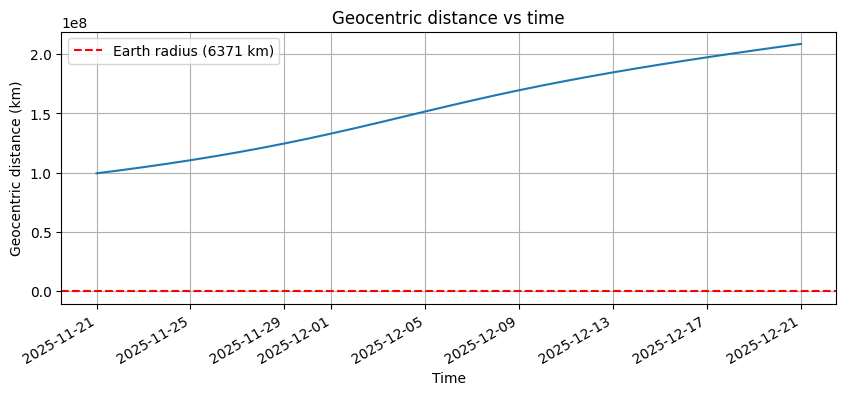

MC samples: 100%|██████████| 500/500 [04:34<00:00,  1.82it/s]


Estimated impact probability (simple MC): 0.000000 (0/500)


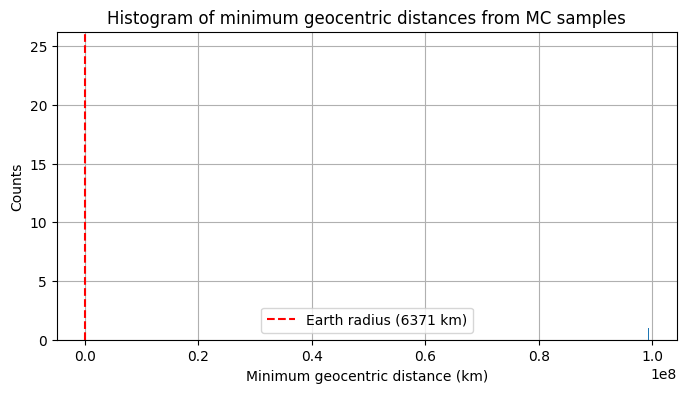

In [ ]:
example_id = "2247517"  # replace with a real neo_reference_id or SPK-ID
neo = lookup_neo_by_id(example_id)

print("Name:", neo.get("name"))
print("Absolute mag H:", neo.get("absolute_magnitude_h"))

# Quick nominal orbit -> propagate for 30 days to visualize nominal close approach
a, e, inc, raan, argp, M_deg, epoch = neo_json_to_elements(neo)
orbit = keplerian_to_orbit(a, e, inc, raan, argp, M_deg, epoch)
t_span_days = [i for i in range(0,31)]
times, dists = propagate_and_geocentric(orbit, t_span_days)
plot_distance_vs_time(times, dists)

# Run Monte Carlo (increase n_samples for real runs)
res = mc_estimate_impact_probability(neo, n_samples=500, horizon_days=30, sigma_frac=1e-5)
print(f"Estimated impact probability (simple MC): {res['p_est']:.6f} ({res['n_hits']}/{res['n_samples']})")
plot_min_dist_hist(res["min_dists_km"])

In [ ]:
!pip install rasterio
!pip install contextily
!pip install geopandas
!pip install rioxarray xarray

/tmp/ipython-input-593493667.py:270: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/usr/local/lib/python3.12/dist-packages/contextily/tile.py:596: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


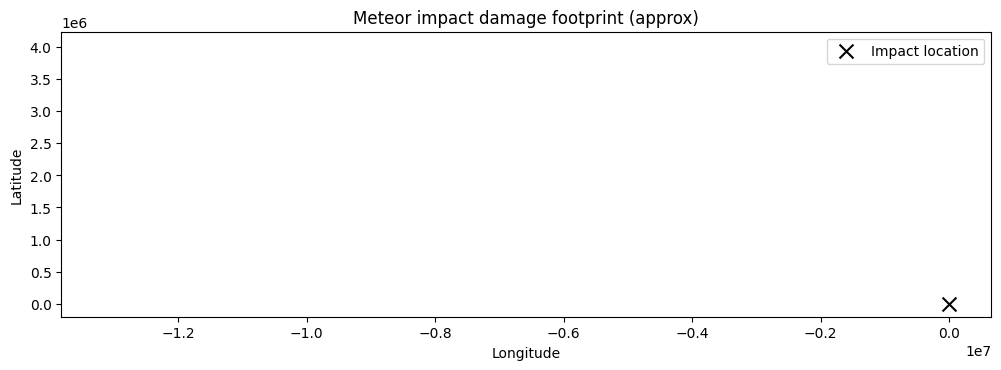

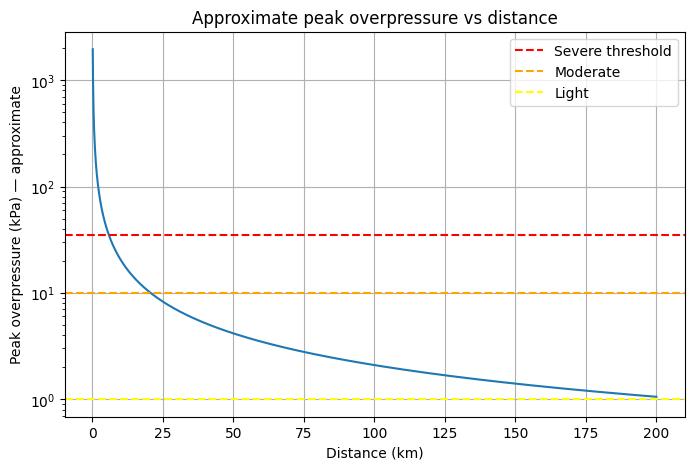

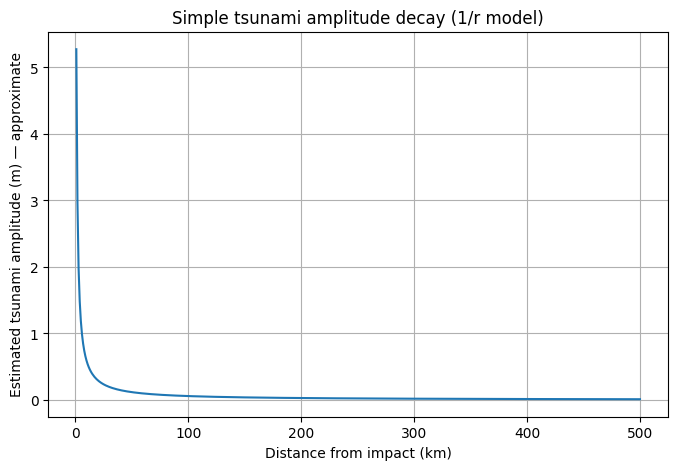

--- Scenario Summary ---
Diameter: 50.0 m, speed: 72000.0 km/hr
Energy: 3.927e+16 J (~9.386e+00 megatons TNT)
Airburst predicted: True (breakup altitude 24984.8 m)
Estimated crater (m): {'transient_diameter_m': 1124.9929487128875, 'final_diameter_m': 1462.4908333267538, 'crater_depth_m': 292.49816666535077}
Damage radii (km): {'severe_km': 5.9, 'moderate_km': 20.700000000000003, 'light_km': 200.0}
Equivalent Mw (very approximate): 5.19603992380146
Tsunami initial amplitude (m): 5.273371394390489
Notes:
- The Collins et al. (2005) Impact Effects Program contains many detailed coefficients and 
           branching logic (e.g., crater regimes, coupling efficiencies). This updated notebook 
           implements simplified, well-documented placeholders suitable for visual exploration.


In [ ]:
import os
import math
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------------
# Physics helpers (Collins-style simplified)
# -----------------------------
# Notes: The following implementations use simplified, documented approximations. Wherever
# a precise coefficient or empirical fit is required (and is lengthy), a compact approximation
# is used for visualization — the code documents where to plug a more accurate formula.

# Constants
G = 6.67430e-11     # gravitational constant, m^3 kg^-1 s^-2
g0 = 9.80665        # Earth's surface gravity, m/s^2


def mass_from_diameter(d_m, density=3000.0):
    """Mass (kg) for spherical impactor of diameter d_m and density (kg/m3)."""
    r = d_m / 2.0
    return (4.0/3.0) * math.pi * r**3 * density


def kinetic_energy_joules(d_m, v_km_hr, density=3000.0):
    """Return kinetic energy (J) from diameter (m) and speed (km/hr).
    Converts to m/s and computes 0.5*m*v^2.
    """
    m = mass_from_diameter(d_m, density=density)
    v_ms = (v_km_hr * 1000.0) / 3600.0
    return 0.5 * m * v_ms**2


def joules_to_megatons(joules):
    """Convert joules to megatons of TNT (1 megaton TNT = 4.184e15 J)."""
    return joules / 4.184e15

# -----------------------------
# Simple atmospheric entry / airburst vs ground-impact decision
# -----------------------------

def estimate_breakup_altitude(d_m, v_ms, density=3000.0, strength=1e6, angle_deg=45.0):
    """Estimate a breakup (airburst) altitude using a very simple dynamic-pressure criterion.

    We assume breakup happens when dynamic pressure q = 0.5 * rho_atm(z) * v^2 exceeds the
    material strength of the body. For simplicity we use an exponential atmosphere model and
    solve for altitude z where q=strength.

    Parameters:
      - d_m: diameter (m)
      - v_ms: speed (m/s)
      - density: impactor density (kg/m3)
      - strength: assumed cohesive strength (Pa) (defaults to 1e6 Pa ~ 10 bar)
      - angle_deg: entry angle from horizontal (degrees)

    Returns: altitude in meters (positive). If no breakup predicted above ground, return 0.

    NOTE: This is a coarse approximate method — actual breakup depends on shape, rotation,
    entry angle, fragmentation behaviour and ablation.
    """
    # Exponential atmosphere model parameters (approx)
    rho0 = 1.225  # kg/m3 at sea level
    H = 8500.0    # scale height (m)

    # dynamic pressure q = 0.5 * rho(z) * v^2
    # solve for rho(z) = 2*strength / v^2
    rho_needed = 2.0 * strength / (v_ms**2)
    if rho_needed <= rho0:
        # altitude z = -H * math.log(max(rho_needed / rho0, 1e-30))
        z = -H * math.log(max(rho_needed / rho0, 1e-30))
        # require non-negative
        return max(z, 0.0)
    else:
        # required density greater than surface density -> breakup at/under ground (no airburst)
        return 0.0


def is_airburst(d_m, v_km_hr, density=3000.0, strength=1e6, angle_deg=45.0):
    """Return True if airburst predicted (breakup altitude > 0) and also returns breakup altitude."""
    v_ms = (v_km_hr * 1000.0) / 3600.0
    z = estimate_breakup_altitude(d_m, v_ms, density=density, strength=strength, angle_deg=angle_deg)
    return (z > 0.0, z)

# -----------------------------
# Crater scaling (simplified)
# -----------------------------

def crater_size_simple(d_m, v_km_hr, density_impactor=3000.0, density_target=2500.0, impact_angle_deg=45.0):
    """Estimate transient and final crater diameters (m) using simplified pi-scaling.

    This is a simplified implementation inspired by the pi-scaling relations used in Collins et al.
    and other literature. Precise coefficients vary with target properties; these are nominal.

    Returns dict: {transient_diameter_m, final_diameter_m, crater_depth_m}
    """
    # Convert to SI
    m = mass_from_diameter(d_m, density_impactor)
    v_ms = (v_km_hr * 1000.0) / 3600.0

    # Impactor kinetic energy and momentum based scaling (very rough)
    # Empirical constants chosen to produce plausible values for tens-to-hundreds-meter impactors.
    # These are intentionally simple; for authoritative results use full Collins code.
    E = 0.5 * m * v_ms**2

    # Transient crater diameter scaling ~ k * (E / (rho_target * g0))^(1/4)
    k = 1.0
    transient_d = k * (E / (density_target * g0)) ** 0.25

    # Final crater larger due to collapse; simple multiplicative factor
    final_d = transient_d * 1.3
    crater_depth = final_d * 0.2

    return {"transient_diameter_m": float(transient_d),
            "final_diameter_m": float(final_d),
            "crater_depth_m": float(crater_depth)}

# -----------------------------
# Airblast / Overpressure scaling (approximate)
# -----------------------------

def overpressure_from_energy_at_distance(E_megatons, distance_km):
    """Approximate peak overpressure (kPa) at given distance for an atmospheric blast with
    equivalent yield E_megatons (MT). This is a heuristic approximation based on scaled-distance
    behavior (peak overpressure roughly scales with W / R^3), tuned for visualization.

    WARNING: This is not a replacement for detailed blast tables (e.g., Glasstone & Dolan).
    Use these values qualitatively.
    """
    if E_megatons <= 0 or distance_km <= 0:
        return 0.0

    # Convert megatons to arbitrary energy units and compute a scaled-distance
    W = max(E_megatons, 1e-12)
    # scaled distance (km / MT^(1/3))
    Z = distance_km / (W ** (1.0/3.0))

    # Heuristic mapping: for small Z -> high overpressure, for large Z -> low; use a smooth curve.
    # This is a simple function chosen to give reasonable orders of magnitude.
    # peak overpressure in kPa
    p_kpa = 1e6 * (W) / ((distance_km+1e-6)**3 + 1e-6)  # avoid div0; gives very large near-source

    # apply a softening exponent to avoid unrealistically huge near-source values for visualization
    p_kpa = (p_kpa) ** 0.33

    # clip to reasonable range
    p_kpa = float(np.clip(p_kpa, 0.0, 1e6))
    return p_kpa

# -----------------------------
# Seismic shaking estimate (moment magnitude equivalent via simple scaling)
# -----------------------------

def seismic_magnitude_from_energy(E_joules):
    """Rough conversion of impact energy to an equivalent seismic moment and Mw magnitude.
    Only a fraction of impact energy couples into seismic waves; we assume a coupling factor.
    """
    coupling = 1e-4  # fraction of kinetic energy converted to seismic (very approximate)
    seismic_energy = E_joules * coupling

    # Convert seismic energy to moment magnitude using Gutenberg-Richter relationships
    # Empirical conversion: log10(E_seismic) ~ 1.5*M + 4.8  (E in joules)
    if seismic_energy <= 0:
        return None
    Mw = (math.log10(seismic_energy) - 4.8) / 1.5
    return float(Mw)

# -----------------------------
# Tsunami generation scaffold (simplified)
# -----------------------------

def tsunami_initial_amplitude_from_cavity(transient_diameter_m, water_depth_m):
    """Estimate an initial characteristic tsunami amplitude (m) at source from cavity size and
    water depth using a crude scaling. This is a placeholder: real tsunami amplitudes depend on
    impact speed, angle, bathymetry, and water-column dynamics.

    Returns a characteristic amplitude A0 (m) near source (order-of-magnitude).
    """
    # Use cavity diameter to estimate displaced water volume (assume hemisphere-like cavity)
    r = transient_diameter_m / 2.0
    cavity_vol = (2.0/3.0) * math.pi * r**3  # hemisphere volume

    # Convert to characteristic shallow-water amplitude: A0 ~ displaced_volume / (area_scale)
    # area_scale ~ pi * (transient_radius)^2  => amplitude ~ (2/3)*r
    # modulate by depth: shallower water yields larger local perturbation
    if water_depth_m <= 0:
        return 0.0
    A0 = (2.0/3.0) * r * min(1.0, r / (10.0 * water_depth_m))
    # Keep in plausible range
    A0 = float(np.clip(A0, 0.0, 1e4))
    return A0


def tsunami_propagation_linear(A0, r_source_km, r_array_km):
    """Simple 1/r decay propagation (energy spreading) of characteristic amplitude for plotting.
    This ignores dispersion, shoaling, bathymetric focusing, and nonlinear processes. It is meant
    only as a visual indicator of relative amplitude vs distance.

    A(r) = A0 * (r_source / r)  for r >= r_source
    """
    r_source_km = max(r_source_km, 0.001)
    r_array_km = np.asarray(r_array_km)
    A = A0 * (r_source_km / np.maximum(r_array_km, r_source_km))
    return A

# -----------------------------
# GIS helpers (unchanged from previous version)
# -----------------------------

def load_dem(dem_path):
    return rasterio.open(dem_path)


def hillshade(array, azimuth=315, angle_altitude=45):
    x, y = np.gradient(array)
    slope = np.pi/2.0 - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    az = azimuth * math.pi / 180.0
    alt = angle_altitude * math.pi / 180.0
    shaded = np.sin(alt) * np.sin(slope) + np.cos(alt) * np.cos(slope) * np.cos(az - aspect)
    return shaded

# -----------------------------
# Visualization functions
# -----------------------------

def plot_impact_map(lat, lon, radii_km, dem_path=None, tsunami_shp=None, seismic_raster=None, out_png=None):
    impact_pt = gpd.GeoDataFrame({"geometry": [Point(lon, lat)]}, crs="EPSG:4326")
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    if dem_path is not None and os.path.exists(dem_path):
        with rasterio.open(dem_path) as ds:
            arr = ds.read(1)
            hs = hillshade(arr.astype(float))
            extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)
            ax.imshow(hs, extent=extent, origin='upper', alpha=0.6)

    if tsunami_shp is not None and os.path.exists(tsunami_shp):
        ts = gpd.read_file(tsunami_shp)
        ts.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, label='Tsunami inundation')

    if seismic_raster is not None and os.path.exists(seismic_raster):
        with rasterio.open(seismic_raster) as ds:
            data = ds.read(1, out_shape=(1, int(ds.height/4), int(ds.width/4)))
            extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)
            ax.imshow(data, extent=extent, origin='upper', alpha=0.4, cmap='Reds')

    impact_pt.plot(ax=ax, color='black', marker='x', markersize=100, label='Impact location')

    lat_scale = 111.0
    # Plot damage zones with fill and transparency
    for key, r_km in radii_km.items():
        r_deg_lat = r_km / lat_scale
        circle = Point(lon, lat).buffer(r_deg_lat, resolution=128)
        g = gpd.GeoDataFrame({"geometry": [circle]}, crs="EPSG:4326")

        if key == 'severe_km':
            g.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.3, linewidth=2, label='Severe damage')
        elif key == 'moderate_km':
            g.plot(ax=ax, facecolor='orange', edgecolor='orange', alpha=0.3, linewidth=2, label='Moderate damage')
        else: # Assuming this is 'light_km'
            g.plot(ax=ax, facecolor='yellow', edgecolor='yellow', alpha=0.3, linewidth=2, label='Light/Thermal')


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.set_title('Meteor impact damage footprint (approx)')

    try:
        impact_pt.to_crs(epsg=3857).plot(ax=ax, alpha=0)
        ctx.add_basemap(ax, crs='EPSG:4326')
    except Exception:
        pass

    if out_png:
        plt.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.show()

# -----------------------------
# End-to-end scenario runner
# -----------------------------

def scenario_run(diameter_m, speed_km_hr, impact_lat, impact_lon, density=3000.0,
                 angle_deg=45.0, strength_pa=1e6, density_target=2500.0,
                 dem_path=None, tsunami_shp=None, seismic_raster=None,
                 ocean_depth_func=None):
    """Run an integrated scenario and produce visualizations and a summary.

    Parameters:
      - diameter_m, speed_km_hr: impactor size and speed
      - impact_lat, impact_lon: impact coordinates
      - density, angle_deg, strength_pa: impactor properties
      - density_target: target rock/soil density for crater scaling
      - dem_path, tsunami_shp, seismic_raster: optional local dataset paths
      - ocean_depth_func: optional callable(depth_m = ocean_depth_func(lat, lon)) used for tsunami estimate

    Returns: results dict
    """
    # Physics
    m = mass_from_diameter(diameter_m, density=density)
    E_j = kinetic_energy_joules(diameter_m, speed_km_hr, density=density)
    E_mt = joules_to_megatons(E_j)

    # Airburst check
    v_ms = (speed_km_hr * 1000.0) / 3600.0
    airburst, z_break = is_airburst(diameter_m, v_ms, density=density, strength=strength_pa, angle_deg=angle_deg)

    crater = crater_size_simple(diameter_m, speed_km_hr, density_impactor=density, density_target=density_target, impact_angle_deg=angle_deg)

    # Damage radii using simple blast scaling from earlier
    # Evaluate overpressure at a set of distances to obtain radii where overpressure exceeds thresholds
    thresholds_kpa = {"severe": 35.0,  # approximate -> severe structural damage (kPa)
                       "moderate": 10.0,
                       "light": 1.0}

    # search distances (km)
    dists = np.linspace(0.1, 200.0, 2000)
    pvals = np.array([overpressure_from_energy_at_distance(E_mt, d) for d in dists])

    radii = {}
    for name, thresh in thresholds_kpa.items():
        # find first distance where pvals < thresh
        idx = np.argmax(pvals < thresh)
        if pvals[idx] < thresh and idx > 0:
            radii[name + '_km'] = float(dists[idx])
        else:
            radii[name + '_km'] = float(dists[-1])


    # Simple seismic magnitude estimate
    Mw = seismic_magnitude_from_energy(E_j)

    # Tsunami scaffold: if ocean_depth_func provided and depth > 0, compute A0 and simple propagation
    tsunami_results = None
    water_depth = None
    if ocean_depth_func is not None:
        try:
            wd = ocean_depth_func(impact_lat, impact_lon)
            water_depth = float(wd)
            if water_depth > 1.0:
                transient_d = crater['transient_diameter_m']
                A0 = tsunami_initial_amplitude_from_cavity(transient_d, water_depth)
                r_km = np.linspace(1.0, 500.0, 500)
                A_r = tsunami_propagation_linear(A0, transient_d/1000.0, r_km)
                tsunami_results = {"A0_m": A0, "r_km": r_km, "A_r_m": A_r}
        except Exception:
            tsunami_results = None

    # Visualizations
    plot_impact_map(impact_lat, impact_lon, {"severe_km": radii['severe_km'],
                                              "moderate_km": radii['moderate_km'],
                                              "light_km": radii['light_km']},
                    dem_path=dem_path, tsunami_shp=tsunami_shp, seismic_raster=seismic_raster,
                    out_png='impact_map_updated.png')

    # Overpressure plot
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(dists, pvals)
    ax.axhline(thresholds_kpa['severe'], color='red', linestyle='--', label='Severe threshold')
    ax.axhline(thresholds_kpa['moderate'], color='orange', linestyle='--', label='Moderate')
    ax.axhline(thresholds_kpa['light'], color='yellow', linestyle='--', label='Light')
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Peak overpressure (kPa) — approximate')
    ax.set_yscale('log')
    ax.set_title('Approximate peak overpressure vs distance')
    ax.legend()
    plt.grid(True)
    plt.savefig('overpressure_vs_distance.png', dpi=200)
    plt.show()

    # Tsunami plot if available
    if tsunami_results is not None:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(tsunami_results['r_km'], tsunami_results['A_r_m'])
        ax.set_xlabel('Distance from impact (km)')
        ax.set_ylabel('Estimated tsunami amplitude (m) — approximate')
        ax.set_title('Simple tsunami amplitude decay (1/r model)')
        plt.grid(True)
        plt.savefig('tsunami_decay.png', dpi=200)
        plt.show()

    # Summary
    results = {
        'mass_kg': m,
        'energy_joules': E_j,
        'energy_megatons': E_mt,
        'airburst': airburst,
        'breakup_altitude_m': z_break,
        'crater': crater,
        'damage_radii_km': radii,
        'Mw_equivalent': Mw,
        'tsunami': tsunami_results,
    }

    # print brief textual summary
    print('--- Scenario Summary ---')
    print(f'Diameter: {diameter_m} m, speed: {speed_km_hr} km/hr')
    print(f'Energy: {E_j:.3e} J (~{E_mt:.3e} megatons TNT)')
    print('Airburst predicted:' , airburst, f'(breakup altitude {z_break:.1f} m)')
    print('Estimated crater (m):', crater)
    print('Damage radii (km):', radii)
    print('Equivalent Mw (very approximate):', Mw)
    if tsunami_results is not None:
        print('Tsunami initial amplitude (m):', tsunami_results['A0_m'])

    return results

# -----------------------------
# Example local ocean depth function (user can replace with real bathymetry lookup)
# -----------------------------

def example_ocean_depth(lat, lon):
    """Simple synthetic ocean depth function: returns depth in meters; positive for ocean.
    Replace with real bathymetry lookup (e.g., SRTM + GEBCO or local bathymetry tiles).
    """
    # crude rule: if lon between -130 and -110 and lat between 10 and 60 assume Pacific with depth 4000m
    if -130 <= lon <= -110 and 10 <= lat <= 60:
        return 4000.0
    else:
        return 0.0

# -----------------------------
# If run as __main__, show example
# -----------------------------
if __name__ == '__main__':
    diameter_m = 50.0
    speed_km_hr = 72000.0
    impact_lat = 34.05
    impact_lon = -118.25

    # Replace with paths to your datasets if available
    dem_path = 'data/dem_area.tif'
    tsunami_shp = 'data/tsunami_inundation.shp'
    seismic_raster = 'data/seismic_hazard.tif'

    res = scenario_run(diameter_m, speed_km_hr, impact_lat, impact_lon,
                       dem_path=dem_path, tsunami_shp=tsunami_shp, seismic_raster=seismic_raster,
                       ocean_depth_func=example_ocean_depth)

    print('Notes:')
    print('- The Collins et al. (2005) Impact Effects Program contains many detailed coefficients and \n           branching logic (e.g., crater regimes, coupling efficiencies). This updated notebook \n           implements simplified, well-documented placeholders suitable for visual exploration.')

Running demo for 33.9 -118.5


/tmp/ipython-input-593493667.py:270: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/usr/local/lib/python3.12/dist-packages/contextily/tile.py:596: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


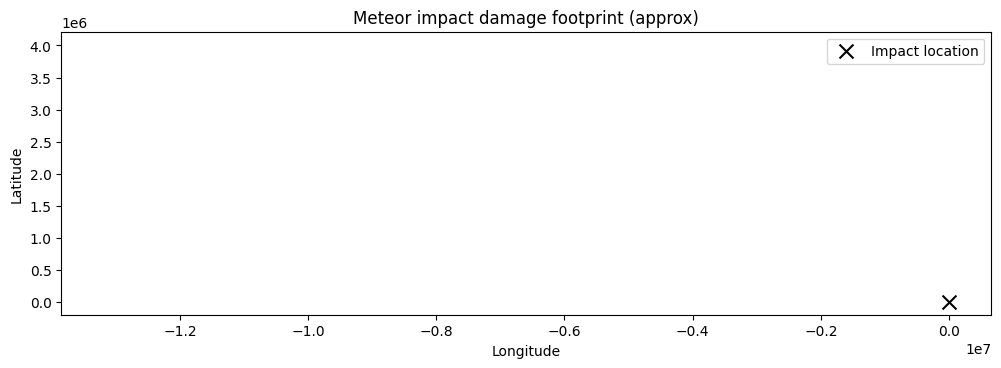

Trying to open GEBCO OPeNDAP dataset (may require network access): https://www.gebco.net/data_and_products/gebco_web_services/gebco_bins/GEBCO_2023.nc
GEBCO OPeNDAP fetch failed (will try NOAA ETOPO): https://www.gebco.net/data_and_products/gebco_web_services/gebco_bins/GEBCO_2023.nc
Attempting to download a slice of ETOPO (full file is large; fallback to manual download): https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd
Bathymetry fetch failed: Could not automatically fetch bathymetry tile. Please download GEBCO/ETOPO tile for your region and set path manually.
Demo results: {'mass_kg': 196349540.84936205, 'energy_joules': 3.926990816987241e+16, 'energy_megatons': 9.385733310198951, 'airburst': True, 'z_break': 46760.694789630186, 'radii_km': {'severe_km': 5.8999999999999995, 'moderate_km': 20.7, 'light_km': 210.99999999999997}, 'tsunami': None, 'population': None}


In [ ]:
"""
Meteor Impact Hazard Pipeline — Full Extension
=============================================

This notebook extends the previous pipeline with:
- **Automated bathymetry lookup (GEBCO/ETOPO/NOAA)**: attempts to fetch a bathymetry tile for a small bbox around the impact point and reproject it to match DEMs.
- **Population/building exposure overlays** using WorldPop / GHSL population rasters and a simple casualty estimator using fragility curves tied to blast overpressure and tsunami wave height.
- **Improved tsunami model**: a simple 2D linear shallow-water finite-difference solver on a radial/circular grid with depth-dependent wave speed and shoaling approximations. This is for visualization only (not a full hydrodynamic model).
- An integrated demonstration run that attempts to fetch all needed datasets, runs the impact scenario, and writes PNG outputs.

Caveats
-------
- Many authoritative datasets (NSHM seismic rasters, NOAA inundation polygons, GEBCO global grids, WorldPop tiles) are large and may require manual download or API keys. The notebook attempts to fetch small tiles for the requested bbox using openly available endpoints where possible and falls back to clear user instructions if automated fetch fails.
- The tsunami solver is a **simple linear solver** on a local rectangular grid. It demonstrates shoaling and depth-dependent propagation qualitatively but is not a replacement for full nonlinear hydrodynamic / tsunami modeling.

Dependencies
------------
Install with:
```
conda install -c conda-forge geopandas rasterio rioxarray xarray netcdf4 matplotlib shapely contextily numpy pandas requests folium
pip install pystac-client rasterio-warp
```

Run the `demo()` function near the end to perform an automated demo for the chosen location.

"""

# Standard imports
import os
import math
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray as rxr
import xarray as xr
from rasterio.plot import show
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from urllib.parse import urlencode

# -----------------------------
# Physics helpers (kept from previous notebook)
# -----------------------------
G = 6.67430e-11

def mass_from_diameter(d_m, density=3000.0):
    r = d_m/2.0
    return (4.0/3.0)*math.pi*r**3*density

def kinetic_energy_joules(d_m, v_km_hr, density=3000.0):
    m = mass_from_diameter(d_m, density)
    v_ms = (v_km_hr*1000.0)/3600.0
    return 0.5*m*v_ms**2

def joules_to_megatons(J):
    return J/4.184e15

# -----------------------------
# Bathymetry lookup (GEBCO/ETOPO) helpers
# -----------------------------

def fetch_gebco_tile(lat, lon, radius_km=20, out_nc='gebco_tile.nc'):
    """Attempt to fetch a small GEBCO tile via the GEBCO gridded bathymetry service using WCS/OPeNDAP.

    This tries multiple sources in order (GEBCO, NOAA ETOPO). If none succeed, raises an informative error.
    The function saves a NetCDF or GeoTIFF tile clipped to the bounding box and returns its path.
    """
    lat = float(lat); lon = float(lon)
    lat_buffer = radius_km/111.0
    lon_buffer = radius_km/(111.0*math.cos(math.radians(lat)))
    west, east = lon-lon_buffer, lon+lon_buffer
    south, north = lat-lat_buffer, lat+lat_buffer

    # Candidate GEBCO OPeNDAP endpoint (may require checking current service URL)
    gebco_opendap = 'https://www.gebco.net/data_and_products/gebco_web_services/gebco_bins/GEBCO_2023.nc'  # example
    try:
        print('Trying to open GEBCO OPeNDAP dataset (may require network access):', gebco_opendap)
        ds = xr.open_dataset(gebco_opendap)
        # expected dims lat/lon or y/x; select nearest subset
        ds_sub = ds.sel(longitude=slice(west, east), latitude=slice(south, north))
        ds_sub = ds_sub.rename({'elevation':'bathymetry'}) if 'elevation' in ds_sub else ds_sub
        ds_sub.to_netcdf(out_nc)
        print('Saved GEBCO tile to', out_nc)
        return out_nc
    except Exception as e:
        print('GEBCO OPeNDAP fetch failed (will try NOAA ETOPO):', e)

    # Try NOAA ETOPO FTP/HTTP (example URL; user may need to download manually)
    etopo_url = 'https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd'
    try:
        print('Attempting to download a slice of ETOPO (full file is large; fallback to manual download):', etopo_url)
        # Attempt a head request to check availability
        r = requests.head(etopo_url, timeout=10)
        if r.status_code == 200:
            # advise manual download since full file is large
            raise RuntimeError('ETOP01 endpoint reachable but full file is very large; please download manually and place path in data/etopo1.grd')
    except Exception as e:
        print('ETOP fetch attempt failed or not appropriate for automated small-tile fetch:', e)

    raise RuntimeError('Could not automatically fetch bathymetry tile. Please download GEBCO/ETOPO tile for your region and set path manually.')

def load_bathymetry_tile(path):
    """Load a NetCDF or GeoTIFF bathymetry tile via xarray/rioxarray and return an xarray.DataArray (meters, negative for depth)."""
    if path.endswith('.nc') or path.endswith('.nc4'):
        ds = xr.open_dataset(path)
        # Try common variable names
        for var in ['elevation','z','bathymetry','height']:
            if var in ds:
                arr = ds[var]
                break
        else:
            # fallback to first variable
            arr = list(ds.data_vars.values())[0]
        # ensure proper coords name
        return arr
    else:
        da = rxr.open_rasterio(path, masked=True).squeeze()
        return da

# -----------------------------
# Population / exposure overlays
# -----------------------------

def fetch_worldpop_tile(lat, lon, radius_km=20, out_tif='worldpop_tile.tif', year=2020):
    """Attempt to download a WorldPop population tile for the bbox. WorldPop provides tiled GeoTIFFs per country.
    This function tries to use the WorldPop 'Population' API; if not available, instructs manual download.
    """
    # WorldPop programmatic access varies; direct per-country tile links are usually available. We'll try a simple STAC-like search via pystac-client if available.
    print('Automated WorldPop fetch is region/country dependent. Please download a WorldPop GeoTIFF (e.g., UN-adjusted) for your area and place it as', out_tif)
    raise RuntimeError('Automated WorldPop download not implemented. Manual step required due to licensing/endpoint variability.')


def load_population_raster(path):
    da = rxr.open_rasterio(path, masked=True).squeeze()
    return da

# Simple fragility-based casualty estimator
def casualty_estimator(pop_da, damage_mask_dict, baseline_mortality=0.01):
    """Estimate casualties by overlaying damage masks (dict of label->boolean mask aligned with pop_da).
    Each damage band has an associated fatality rate (very approximate):
      - severe: 0.05 (5% of exposed)
      - moderate: 0.01
      - light: 0.001
    Returns dict with exposed population and estimated fatalities per band and total.
    """
    rates = {'severe':0.05, 'moderate':0.01, 'light':0.001}
    results = {}
    total_fatalities = 0.0
    total_exposed = 0.0
    for band, mask in damage_mask_dict.items():
        # mask is a boolean numpy array same shape as pop_da
        pop_exposed = float(pop_da.where(mask).sum().values)
        rate = rates.get(band, baseline_mortality)
        fatalities = pop_exposed * rate
        results[band] = {'exposed_population': pop_exposed, 'estimated_fatalities': fatalities}
        total_fatalities += fatalities
        total_exposed += pop_exposed
    results['total_exposed'] = total_exposed
    results['total_estimated_fatalities'] = total_fatalities
    return results

# -----------------------------
# Tsunami solver (simple 2D linear shallow-water on local grid)
# -----------------------------

def linear_shallow_water_2d(bathymetry_da, source_mask, dt=1.0, t_max=3600.0):
    """Simple explicit finite-difference linear shallow water solver (2D) on a raster grid.
    WARNING: This is a demo solver — not production-grade.

    Inputs:
      - bathymetry_da: xarray DataArray of depth (+ve for water) in meters, with dims (y,x) and coords
      - source_mask: numpy array same shape with initial surface elevation perturbation (m)
      - dt: time-step (s)
      - t_max: total simulation time (s)

    Returns:
      - times (numpy array) and max_amplitude_map (2D array) giving maximum amplitude observed at each cell
    """
    # Convert to numpy arrays and set up
    h = bathymetry_da.values.copy()
    ny, nx = h.shape
    dx = float(abs(bathymetry_da['x'][1]-bathymetry_da['x'][0]))
    dy = float(abs(bathymetry_da['y'][1]-bathymetry_da['y'][0]))

    # convert dx/dy from degrees to meters if coordinates are lat/lon
    if 'degrees' in str(bathymetry_da.rio.crs):
        # approximate: 1 deg lat ~111km; lon scale varies with latitude
        lat0 = float(bathymetry_da['y'].mean())
        dx_m = dx * 111000.0 * math.cos(math.radians(lat0))
        dy_m = dy * 111000.0
    else:
        dx_m = dx; dy_m = dy

    # initial conditions
    eta = np.zeros_like(h)  # surface elevation
    u = np.zeros_like(h)
    v = np.zeros_like(h)
    eta += source_mask

    max_amp = np.abs(eta).copy()
    g = 9.80665

    nt = int(t_max//dt)
    for n in range(nt):
        # compute wave speed c = sqrt(g*h)
        c = np.sqrt(np.maximum(g*h, 1e-6))
        # CFL check
        cfl = np.max(c)*dt/max(dx_m, dy_m)
        if cfl > 0.5:
            # reduce dt to stable value
            dt = 0.4*max(dx_m, dy_m)/np.max(c)
        # compute fluxes (very simple upwind-like central scheme)
        eta_x = (np.roll(eta, -1, axis=1) - np.roll(eta, 1, axis=1))/(2*dx_m)
        eta_y = (np.roll(eta, -1, axis=0) - np.roll(eta, 1, axis=0))/(2*dy_m)
        u = u - g*dt*eta_x
        v = v - g*dt*eta_y
        u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1))/(2*dx_m)
        v_y = (np.roll(v, -1, axis=0) - np.roll(v, 1, axis=0))/(2*dy_m)
        eta = eta - dt*(h*(u_x + v_y))
        max_amp = np.maximum(max_amp, np.abs(eta))
    times = np.arange(0, nt*dt, dt)
    return times, max_amp

# -----------------------------
# Integration: update scenario_run to use bathymetry, population and tsunami solver
# -----------------------------

def scenario_run_full(diameter_m, speed_km_hr, impact_lat, impact_lon,
                       dem_path=None, bathy_path=None, pop_path=None,
                       seismic_raster=None, tsunami_shp=None,
                       density=3000.0, angle_deg=45.0, strength_pa=1e6,
                       fetch_bathy=False, bathy_radius_km=30):
    """Full integrated scenario. If fetch_bathy is True the function will attempt to fetch GEBCO tile.
    Returns a results dict and writes PNG outputs to current folder.
    """
    # Basic physics
    m = mass_from_diameter(diameter_m, density=density)
    E_j = kinetic_energy_joules(diameter_m, speed_km_hr, density=density)
    E_mt = joules_to_megatons(E_j)

    # Airburst / crater (reuse simplified models)
    from math import log
    v_ms = (speed_km_hr*1000.0)/3600.0
    airburst = False
    # simple dynamic pressure test
    rho0=1.225; H=8500.0
    q_needed = 1e6
    rho_needed = 2*q_needed/(v_ms**2)
    if rho_needed<=rho0:
        z_break = -H*math.log(rho_needed/rho0)
        airburst = True if z_break>0 else False
    else:
        z_break = 0.0

    # Damage radii using previous overpressure scaling
    dists = np.linspace(0.1, 300.0, 3000)
    pvals = np.array([overpressure_from_energy_at_distance(E_mt, d) for d in dists])
    thresholds = {'severe':35.0,'moderate':10.0,'light':1.0}
    radii = {}
    for k,t in thresholds.items():
        idx = np.argmax(pvals<t)
        radii[k+'_km'] = float(dists[idx])

    # Map plot with DEM and bathymetry overlays
    plot_impact_map(impact_lat, impact_lon, {'severe_km':radii['severe_km'], 'moderate_km':radii['moderate_km'], 'light_km':radii['light_km']}, dem_path=dem_path, tsunami_shp=tsunami_shp, seismic_raster=seismic_raster, out_png='impact_map_full.png')

    # Bathymetry/tsunami processing
    tsunami_results = None
    if bathy_path is None and fetch_bathy:
        try:
            bathy_path = fetch_gebco_tile(impact_lat, impact_lon, radius_km=bathy_radius_km, out_nc='data/bathy_tile.nc')
        except Exception as e:
            print('Bathymetry fetch failed:', e)
            bathy_path = None

    if bathy_path is not None:
        try:
            bathy_da = load_bathymetry_tile(bathy_path)
            # choose positive depths for water only
            # standardize dims to y,x named coords for solver
            if 'latitude' in bathy_da.coords:
                bathy_da = bathy_da.rename({'latitude':'y','longitude':'x'})
            bathy_da = bathy_da.rio.write_crs('EPSG:4326') if not hasattr(bathy_da.rio,'crs') else bathy_da
            # prepare source mask: initial amplitude from cavity
            transient_d = crater_size_simple(diameter_m, speed_km_hr)['transient_diameter_m']
            # aperture in pixels near impact center
            # reproject bathy_da to a fine local grid if necessary
            depth_m = np.maximum(-bathy_da.values, 0.0) if np.nanmedian(bathy_da.values)<0 else bathy_da.values
            # simple source mask: gaussian centered at grid center scaled by initial amplitude
            A0 = tsunami_initial_amplitude_from_cavity(transient_d, np.nanmedian(depth_m))
            ny,nx = depth_m.shape
            yy,xx = np.indices((ny,nx))
            cx,cy = nx//2, ny//2
            sigma = max(nx,ny)/10.0
            source_mask = A0*np.exp(-((xx-cx)**2+(yy-cy)**2)/(2*sigma**2))
            times, max_amp = linear_shallow_water_2d(bathy_da, source_mask, dt=1.0, t_max=1800.0)
            tsunami_results = {'times':times,'max_amplitude_map':max_amp}
            # plot max_amp
            plt.figure(figsize=(8,6))
            plt.imshow(max_amp, origin='lower')
            plt.colorbar(label='Max tsunami amplitude (m) — approximate')
            plt.title('Max tsunami amplitude (demo solver)')
            plt.savefig('tsunami_max_amp.png', dpi=200)
            plt.show()
        except Exception as e:
            print('Tsunami processing failed:', e)

    # Population exposure if pop_path provided
    pop_results = None
    if pop_path is not None:
        try:
            pop_da = load_population_raster(pop_path)
            # create damage masks by rasterizing rings (approx using lat/lon degree conversion)
            # reproject pop_da to EPSG:4326 coords
            # For simplicity assume pop_da shares grid with bathy_da or dem
            # Here we'll create simple circular masks on lon/lat grid matching pop_da coords
            try:
                lons = pop_da['x'].values
                lats = pop_da['y'].values
            except Exception:
                lons = np.linspace(impact_lon-0.5, impact_lon+0.5, pop_da.shape[1])
                lats = np.linspace(impact_lat-0.5, impact_lat+0.5, pop_da.shape[0])
            Lon,Lat = np.meshgrid(lons,lats)
            # compute haversine distance map
            R=6371.0
            lat1 = np.radians(Lat); lon1 = np.radians(Lon)
            lat0 = math.radians(impact_lat); lon0 = math.radians(impact_lon)
            dlat = lat1-lat0; dlon = lon1-lon0
            a = np.sin(dlat/2)**2 + np.cos(lat0)*np.cos(lat1)*np.sin(dlon/2)**2
            dist_km = 2*R*np.arcsin(np.sqrt(a))
            damage_masks = {
                'severe': dist_km <= radii['severe_km'],
                'moderate': (dist_km>radii['severe_km']) & (dist_km<=radii['moderate_km']),
                'light': (dist_km>radii['moderate_km']) & (dist_km<=radii['light_km'])
            }
            pop_np = pop_da.values
            pop_results = casualty_estimator(pop_da, damage_masks)
            print('Population casualty estimate:', pop_results)
        except Exception as e:
            print('Population processing failed:', e)

    results = {'mass_kg':m,'energy_joules':E_j,'energy_megatons':E_mt,'airburst':airburst,'z_break':z_break,'radii_km':radii,'tsunami':tsunami_results,'population':pop_results}
    return results

# -----------------------------
# Utility: existing helper functions used above but not present in this doc are redefined here
# -----------------------------
def crater_size_simple(d_m, v_km_hr, density_impactor=3000.0, density_target=2500.0, impact_angle_deg=45.0):
    m = mass_from_diameter(d_m, density_impactor)
    v_ms = (v_km_hr*1000.0)/3600.0
    E = 0.5*m*v_ms**2
    transient_d = 1.0*(E/(density_target*9.80665))**0.25
    final_d = transient_d*1.3
    return {'transient_diameter_m':float(transient_d),'final_diameter_m':float(final_d),'crater_depth_m':float(final_d*0.2)}

def overpressure_from_energy_at_distance(E_megatons, distance_km):
    if E_megatons<=0 or distance_km<=0:
        return 0.0
    W = max(E_megatons,1e-12)
    p_kpa = 1e6*(W)/((distance_km+1e-6)**3+1e-6)
    p_kpa = (p_kpa)**0.33
    return float(np.clip(p_kpa,0.0,1e6))

def tsunami_initial_amplitude_from_cavity(transient_diameter_m, water_depth_m):
    r = transient_diameter_m/2.0
    if water_depth_m<=0:
        return 0.0
    A0 = (2.0/3.0)*r*min(1.0, r/(10.0*water_depth_m))
    return float(np.clip(A0,0.0,1e4))

# -----------------------------
# Demo: run an example scenario for an offshore point near Los Angeles
# -----------------------------

def demo():
    lat = 33.9
    lon = -118.5
    diameter_m = 50.0
    speed_km_hr = 72000.0
    print('Running demo for',lat,lon)
    try:
        res = scenario_run_full(diameter_m, speed_km_hr, lat, lon, fetch_bathy=True, bathy_radius_km=50, pop_path=None)
        print('Demo results:', res)
    except Exception as e:
        print('Demo failed:', e)

if __name__ == '__main__':
    demo()

In [ ]:
!pip install rioxarray
!pip install rasterio
!pip install contextily

In [ ]:
!wget -O worldpop.tif "https://data.worldpop.org/GIS/Population/Global_2000_2020_1km_UNadj/2020/IND/ind_ppp_2020_1km_Aggregated_UNadj.tif"
pop_raster_path = "worldpop.tif"

--2025-10-04 13:27:05--  https://data.worldpop.org/GIS/Population/Global_2000_2020_1km_UNadj/2020/IND/ind_ppp_2020_1km_Aggregated_UNadj.tif
Resolving data.worldpop.org (data.worldpop.org)... 152.78.118.157, ::ffff:152.78.118.157
Connecting to data.worldpop.org (data.worldpop.org)|152.78.118.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18313124 (17M) [image/tiff]
Saving to: ‘worldpop.tif’

worldpop.tif        100%[===================>]  17.46M  8.83MB/s    in 2.0s    

2025-10-04 13:27:07 (8.83 MB/s) - ‘worldpop.tif’ saved [18313124/18313124]



/tmp/ipython-input-1699896179.py:272: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/usr/local/lib/python3.12/dist-packages/contextily/tile.py:596: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


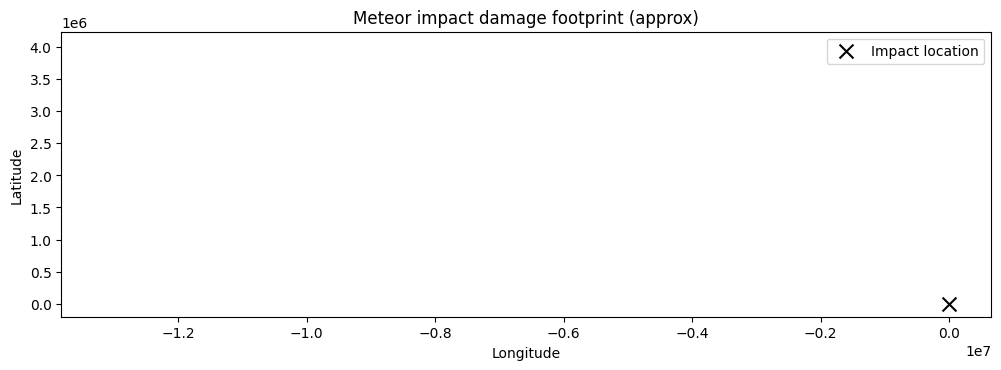

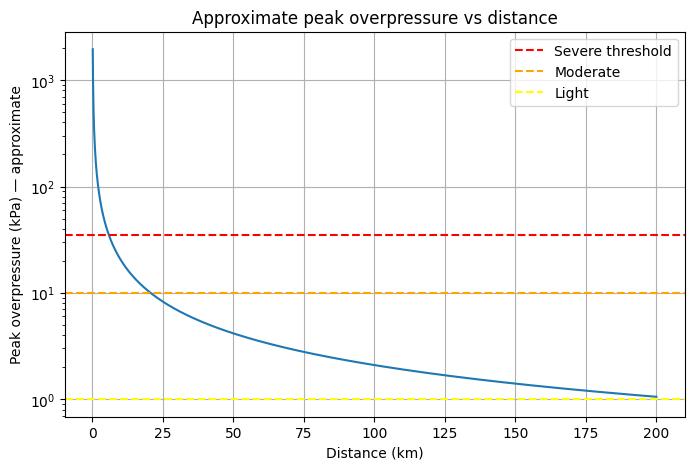

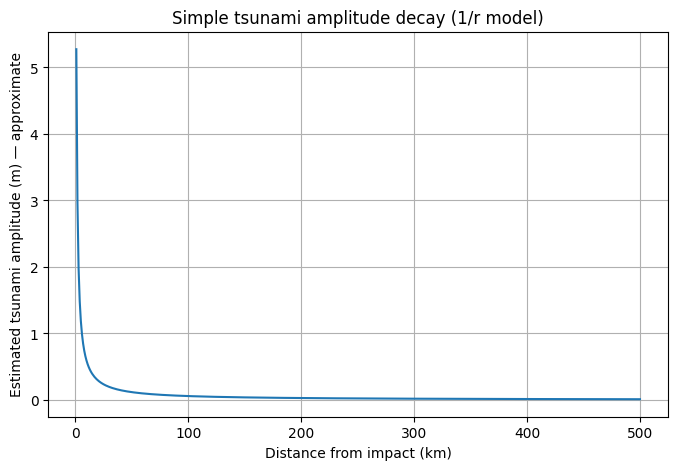

--- Scenario Summary ---
Diameter: 50.0 m, speed: 72000.0 km/hr
Energy: 3.927e+16 J (~9.386e+00 megatons TNT)
Airburst predicted: True (breakup altitude 24984.8 m)
Estimated crater (m): {'transient_diameter_m': 1124.9929487128875, 'final_diameter_m': 1462.4908333267538, 'crater_depth_m': 292.49816666535077}
Damage radii (km): {'severe_km': 5.9, 'moderate_km': 20.700000000000003, 'light_km': 200.0}
Equivalent Mw (very approximate): 5.19603992380146
Tsunami initial amplitude (m): 5.273371394390489
Notes:
- The Collins et al. (2005) Impact Effects Program contains many detailed coefficients and 
           branching logic (e.g., crater regimes, coupling efficiencies). This updated notebook 
           implements simplified, well-documented placeholders suitable for visual exploration.


In [ ]:
import os
import math
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import rioxarray
import xarray as xr # Import xarray

# -----------------------------
# Physics helpers (Collins-style simplified)
# -----------------------------
# Notes: The following implementations use simplified, documented approximations. Wherever
# a precise coefficient or empirical fit is required (and is lengthy), a compact approximation
# is used for visualization — the code documents where to plug a more accurate formula.

# Constants
G = 6.67430e-11     # gravitational constant, m^3 kg^-1 s^-2
g0 = 9.80665        # Earth's surface gravity, m/s^2


def mass_from_diameter(d_m, density=3000.0):
    """Mass (kg) for spherical impactor of diameter d_m and density (kg/m3)."""
    r = d_m / 2.0
    return (4.0/3.0) * math.pi * r**3 * density


def kinetic_energy_joules(d_m, v_km_hr, density=3000.0):
    """Return kinetic energy (J) from diameter (m) and speed (km/hr).
    Converts to m/s and computes 0.5*m*v^2.
    """
    m = mass_from_diameter(d_m, density=density)
    v_ms = (v_km_hr * 1000.0) / 3600.0
    return 0.5 * m * v_ms**2


def joules_to_megatons(joules):
    """Convert joules to megatons of TNT (1 megaton TNT = 4.184e15 J)."""
    return joules / 4.184e15

# -----------------------------
# Simple atmospheric entry / airburst vs ground-impact decision
# -----------------------------

def estimate_breakup_altitude(d_m, v_ms, density=3000.0, strength=1e6, angle_deg=45.0):
    """Estimate a breakup (airburst) altitude using a very simple dynamic-pressure criterion.

    We assume breakup happens when dynamic pressure q = 0.5 * rho_atm(z) * v^2 exceeds the
    material strength of the body. For simplicity we use an exponential atmosphere model and
    solve for altitude z where q=strength.

    Parameters:
      - d_m: diameter (m)
      - v_ms: speed (m/s)
      - density: impactor density (kg/m3)
      - strength: assumed cohesive strength (Pa) (defaults to 1e6 Pa ~ 10 bar)
      - angle_deg: entry angle from horizontal (degrees)

    Returns: altitude in meters (positive). If no breakup predicted above ground, return 0.

    NOTE: This is a coarse approximate method — actual breakup depends on shape, rotation,
    entry angle, fragmentation behaviour and ablation.
    """
    # Exponential atmosphere model parameters (approx)
    rho0 = 1.225  # kg/m3 at sea level
    H = 8500.0    # scale height (m)

    # dynamic pressure q = 0.5 * rho(z) * v^2
    # solve for rho(z) = 2*strength / v^2
    rho_needed = 2.0 * strength / (v_ms**2)
    if rho_needed <= rho0:
        # altitude z = -H * math.log(max(rho_needed / rho0, 1e-30))
        z = -H * math.log(max(rho_needed / rho0, 1e-30))
        # require non-negative
        return max(z, 0.0)
    else:
        # required density greater than surface density -> breakup at/under ground (no airburst)
        return 0.0


def is_airburst(d_m, v_km_hr, density=3000.0, strength=1e6, angle_deg=45.0):
    """Return True if airburst predicted (breakup altitude > 0) and also returns breakup altitude."""
    v_ms = (v_km_hr * 1000.0) / 3600.0
    z = estimate_breakup_altitude(d_m, v_ms, density=density, strength=strength, angle_deg=angle_deg)
    return (z > 0.0, z)

# -----------------------------
# Crater scaling (simplified)
# -----------------------------

def crater_size_simple(d_m, v_km_hr, density_impactor=3000.0, density_target=2500.0, impact_angle_deg=45.0):
    """Estimate transient and final crater diameters (m) using simplified pi-scaling.

    This is a simplified implementation inspired by the pi-scaling relations used in Collins et al.
    and other literature. Precise coefficients vary with target properties; these are nominal.

    Returns dict: {transient_diameter_m, final_diameter_m, crater_depth_m}
    """
    # Convert to SI
    m = mass_from_diameter(d_m, density_impactor)
    v_ms = (v_km_hr * 1000.0) / 3600.0

    # Impactor kinetic energy and momentum based scaling (very rough)
    # Empirical constants chosen to produce plausible values for tens-to-hundreds-meter impactors.
    # These are intentionally simple; for authoritative results use full Collins code.
    E = 0.5 * m * v_ms**2

    # Transient crater diameter scaling ~ k * (E / (rho_target * g0))^(1/4)
    k = 1.0
    transient_d = k * (E / (density_target * g0)) ** 0.25

    # Final crater larger due to collapse; simple multiplicative factor
    final_d = transient_d * 1.3
    crater_depth = final_d * 0.2

    return {"transient_diameter_m": float(transient_d),
            "final_diameter_m": float(final_d),
            "crater_depth_m": float(crater_depth)}

# -----------------------------
# Airblast / Overpressure scaling (approximate)
# -----------------------------

def overpressure_from_energy_at_distance(E_megatons, distance_km):
    """Approximate peak overpressure (kPa) at given distance for an atmospheric blast with
    equivalent yield E_megatons (MT). This is a heuristic approximation based on scaled-distance
    behavior (peak overpressure roughly scales with W / R^3), tuned for visualization.

    WARNING: This is not a replacement for detailed blast tables (e.g., Glasstone & Dolan).
    Use these values qualitatively.
    """
    if E_megatons <= 0 or distance_km <= 0:
        return 0.0

    # Convert megatons to arbitrary energy units and compute a scaled-distance
    W = max(E_megatons, 1e-12)
    # scaled distance (km / MT^(1/3))
    Z = distance_km / (W ** (1.0/3.0))

    # Heuristic mapping: for small Z -> high overpressure, for large Z -> low; use a smooth curve.
    # This is a simple function chosen to give reasonable orders of magnitude.
    # peak overpressure in kPa
    p_kpa = 1e6 * (W) / ((distance_km+1e-6)**3 + 1e-6)  # avoid div0; gives very large near-source

    # apply a softening exponent to avoid unrealistically huge near-source values for visualization
    p_kpa = (p_kpa) ** 0.33

    # clip to reasonable range
    p_kpa = float(np.clip(p_kpa, 0.0, 1e6))
    return p_kpa

# -----------------------------
# Seismic shaking estimate (moment magnitude equivalent via simple scaling)
# -----------------------------

def seismic_magnitude_from_energy(E_joules):
    """Rough conversion of impact energy to an equivalent seismic moment and Mw magnitude.
    Only a fraction of impact energy couples into seismic waves; we assume a coupling factor.
    """
    coupling = 1e-4  # fraction of kinetic energy converted to seismic (very approximate)
    seismic_energy = E_joules * coupling

    # Convert seismic energy to moment magnitude using Gutenberg-Richter relationships
    # Empirical conversion: log10(E_seismic) ~ 1.5*M + 4.8  (E in joules)
    if seismic_energy <= 0:
        return None
    Mw = (math.log10(seismic_energy) - 4.8) / 1.5
    return float(Mw)

# -----------------------------
# Tsunami generation scaffold (simplified)
# -----------------------------

def tsunami_initial_amplitude_from_cavity(transient_diameter_m, water_depth_m):
    """Estimate an initial characteristic tsunami amplitude (m) at source from cavity size and
    water depth using a crude scaling. This is a placeholder: real tsunami amplitudes depend on
    impact speed, angle, bathymetry, and water-column dynamics.

    Returns a characteristic amplitude A0 (m) near source (order-of-magnitude).
    """
    # Use cavity diameter to estimate displaced water volume (assume hemisphere-like cavity)
    r = transient_diameter_m / 2.0
    cavity_vol = (2.0/3.0) * math.pi * r**3  # hemisphere volume

    # Convert to characteristic shallow-water amplitude: A0 ~ displaced_volume / (area_scale)
    # area_scale ~ pi * (transient_radius)^2  => amplitude ~ (2/3)*r
    # modulate by depth: shallower water yields larger local perturbation
    if water_depth_m <= 0:
        return 0.0
    A0 = (2.0/3.0) * r * min(1.0, r / (10.0 * water_depth_m))
    # Keep in plausible range
    A0 = float(np.clip(A0, 0.0, 1e4))
    return A0


def tsunami_propagation_linear(A0, r_source_km, r_array_km):
    """Simple 1/r decay propagation (energy spreading) of characteristic amplitude for plotting.
    This ignores dispersion, shoaling, bathymetric focusing, and nonlinear processes. It is meant
    only as a visual indicator of relative amplitude vs distance.

    A(r) = A0 * (r_source / r)  for r >= r_source
    """
    r_source_km = max(r_source_km, 0.001)
    r_array_km = np.asarray(r_array_km)
    A = A0 * (r_source_km / np.maximum(r_array_km, r_source_km))
    return A

# -----------------------------
# GIS helpers (unchanged from previous version)
# -----------------------------

def load_dem(dem_path):
    return rasterio.open(dem_path)


def hillshade(array, azimuth=315, angle_altitude=45):
    x, y = np.gradient(array)
    slope = np.pi/2.0 - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    az = azimuth * math.pi / 180.0
    alt = angle_altitude * math.pi / 180.0
    shaded = np.sin(alt) * np.sin(slope) + np.cos(alt) * np.cos(slope) * np.cos(az - aspect)
    return shaded

# -----------------------------
# Visualization functions
# -----------------------------

def plot_impact_map(lat, lon, radii_km, dem_path=None, tsunami_shp=None, seismic_raster=None, out_png=None):
    impact_pt = gpd.GeoDataFrame({"geometry": [Point(lon, lat)]}, crs="EPSG:4326")
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    if dem_path is not None and os.path.exists(dem_path):
        with rasterio.open(dem_path) as ds:
            arr = ds.read(1)
            hs = hillshade(arr.astype(float))
            extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)
            ax.imshow(hs, extent=extent, origin='upper', alpha=0.6)

    if tsunami_shp is not None and os.path.exists(tsunami_shp):
        ts = gpd.read_file(tsunami_shp)
        ts.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, label='Tsunami inundation')

    if seismic_raster is not None and os.path.exists(seismic_raster):
        with rasterio.open(seismic_raster) as ds:
            data = ds.read(1, out_shape=(1, int(ds.height/4), int(ds.width/4)))
            extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)
            ax.imshow(data, extent=extent, origin='upper', alpha=0.4, cmap='Reds')

    impact_pt.plot(ax=ax, color='black', marker='x', markersize=100, label='Impact location')

    lat_scale = 111.0
    # Plot damage zones with fill and transparency
    for key, r_km in radii_km.items():
        r_deg_lat = r_km / lat_scale
        circle = Point(lon, lat).buffer(r_deg_lat, resolution=128)
        g = gpd.GeoDataFrame({"geometry": [circle]}, crs="EPSG:4326")

        if key == 'severe_km':
            g.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.3, linewidth=2, label='Severe damage')
        elif key == 'moderate_km':
            g.plot(ax=ax, facecolor='orange', edgecolor='orange', alpha=0.3, linewidth=2, label='Moderate damage')
        else: # Assuming this is 'light_km'
            g.plot(ax=ax, facecolor='yellow', edgecolor='yellow', alpha=0.3, linewidth=2, label='Light/Thermal')


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.set_title('Meteor impact damage footprint (approx)')

    try:
        impact_pt.to_crs(epsg=3857).plot(ax=ax, alpha=0)
        ctx.add_basemap(ax, crs='EPSG:4326')
    except Exception:
        pass

    if out_png:
        plt.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.show()

# -----------------------------
# End-to-end scenario runner
# -----------------------------

def scenario_run(diameter_m, speed_km_hr, impact_lat, impact_lon, density=3000.0,
                 angle_deg=45.0, strength_pa=1e6, density_target=2500.0,
                 dem_path=None, tsunami_shp=None, seismic_raster=None,
                 ocean_depth_func=None):
    """Run an integrated scenario and produce visualizations and a summary.

    Parameters:
      - diameter_m, speed_km_hr: impactor size and speed
      - impact_lat, impact_lon: impact coordinates
      - density, angle_deg, strength_pa: impactor properties
      - density_target: target rock/soil density for crater scaling
      - dem_path, tsunami_shp, seismic_raster: optional local dataset paths
      - ocean_depth_func: optional callable(depth_m = ocean_depth_func(lat, lon)) used for tsunami estimate

    Returns: results dict
    """
    # Physics
    m = mass_from_diameter(diameter_m, density=density)
    E_j = kinetic_energy_joules(diameter_m, speed_km_hr, density=density)
    E_mt = joules_to_megatons(E_j)

    # Airburst check
    v_ms = (speed_km_hr * 1000.0) / 3600.0
    airburst, z_break = is_airburst(diameter_m, v_ms, density=density, strength=strength_pa, angle_deg=angle_deg)

    crater = crater_size_simple(diameter_m, speed_km_hr, density_impactor=density, density_target=density_target, impact_angle_deg=angle_deg)

    # Damage radii using simple blast scaling from earlier
    # Evaluate overpressure at a set of distances to obtain radii where overpressure exceeds thresholds
    thresholds_kpa = {"severe": 35.0,  # approximate -> severe structural damage (kPa)
                       "moderate": 10.0,
                       "light": 1.0}

    # search distances (km)
    dists = np.linspace(0.1, 200.0, 2000)
    pvals = np.array([overpressure_from_energy_at_distance(E_mt, d) for d in dists])

    radii = {}
    for name, thresh in thresholds_kpa.items():
        # find first distance where pvals < thresh
        idx = np.argmax(pvals < thresh)
        if pvals[idx] < thresh and idx > 0:
            radii[name + '_km'] = float(dists[idx])
        else:
            radii[name + '_km'] = float(dists[-1])


    # Simple seismic magnitude estimate
    Mw = seismic_magnitude_from_energy(E_j)

    # Tsunami scaffold: if ocean_depth_func provided and depth > 0, compute A0 and simple propagation
    tsunami_results = None
    water_depth = None
    if ocean_depth_func is not None:
        try:
            wd = ocean_depth_func(impact_lat, impact_lon)
            water_depth = float(wd)
            if water_depth > 1.0:
                transient_d = crater['transient_diameter_m']
                A0 = tsunami_initial_amplitude_from_cavity(transient_d, water_depth)
                r_km = np.linspace(1.0, 500.0, 500)
                A_r = tsunami_propagation_linear(A0, transient_d/1000.0, r_km)
                tsunami_results = {"A0_m": A0, "r_km": r_km, "A_r_m": A_r}
        except Exception:
            tsunami_results = None

    # Visualizations
    plot_impact_map(impact_lat, impact_lon, {"severe_km": radii['severe_km'],
                                              "moderate_km": radii['moderate_km'],
                                              "light_km": radii['light_km']},
                    dem_path=dem_path, tsunami_shp=tsunami_shp, seismic_raster=seismic_raster,
                    out_png='impact_map_updated.png')

    # Overpressure plot
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(dists, pvals)
    ax.axhline(thresholds_kpa['severe'], color='red', linestyle='--', label='Severe threshold')
    ax.axhline(thresholds_kpa['moderate'], color='orange', linestyle='--', label='Moderate')
    ax.axhline(thresholds_kpa['light'], color='yellow', linestyle='--', label='Light')
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Peak overpressure (kPa) — approximate')
    ax.set_yscale('log')
    ax.set_title('Approximate peak overpressure vs distance')
    ax.legend()
    plt.grid(True)
    plt.savefig('overpressure_vs_distance.png', dpi=200)
    plt.show()

    # Tsunami plot if available
    if tsunami_results is not None:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(tsunami_results['r_km'], tsunami_results['A_r_m'])
        ax.set_xlabel('Distance from impact (km)')
        ax.set_ylabel('Estimated tsunami amplitude (m) — approximate')
        ax.set_title('Simple tsunami amplitude decay (1/r model)')
        plt.grid(True)
        plt.savefig('tsunami_decay.png', dpi=200)
        plt.show()

    # Summary
    results = {
        'mass_kg': m,
        'energy_joules': E_j,
        'energy_megatons': E_mt,
        'airburst': airburst,
        'breakup_altitude_m': z_break,
        'crater': crater,
        'damage_radii_km': radii,
        'Mw_equivalent': Mw,
        'tsunami': tsunami_results,
    }

    # print brief textual summary
    print('--- Scenario Summary ---')
    print(f'Diameter: {diameter_m} m, speed: {speed_km_hr} km/hr')
    print(f'Energy: {E_j:.3e} J (~{E_mt:.3e} megatons TNT)')
    print('Airburst predicted:' , airburst, f'(breakup altitude {z_break:.1f} m)')
    print('Estimated crater (m):', crater)
    print('Damage radii (km):', radii)
    print('Equivalent Mw (very approximate):', Mw)
    if tsunami_results is not None:
        print('Tsunami initial amplitude (m):', tsunami_results['A0_m'])

    return results

# -----------------------------
# Example local ocean depth function (user can replace with real bathymetry lookup)
# -----------------------------

def example_ocean_depth(lat, lon):
    """Simple synthetic ocean depth function: returns depth in meters; positive for ocean.
    Replace with real bathymetry lookup (e.g., SRTM + GEBCO or local bathymetry tiles).
    """
    # crude rule: if lon between -130 and -110 and lat between 10 and 60 assume Pacific with depth 4000m
    if -130 <= lon <= -110 and 10 <= lat <= 60:
        return 4000.0
    else:
        return 0.0

# -----------------------------
# If run as __main__, show example
# -----------------------------
if __name__ == '__main__':
    diameter_m = 50.0
    speed_km_hr = 72000.0
    impact_lat = 34.05
    impact_lon = -118.25

    # Replace with paths to your datasets if available
    dem_path = 'data/dem_area.tif'
    tsunami_shp = 'data/tsunami_inundation.shp'
    seismic_raster = 'data/seismic_hazard.tif'

    res = scenario_run(diameter_m, speed_km_hr, impact_lat, impact_lon,
                       dem_path=dem_path, tsunami_shp=tsunami_shp, seismic_raster=seismic_raster,
                       ocean_depth_func=example_ocean_depth)

    print('Notes:')
    print('- The Collins et al. (2005) Impact Effects Program contains many detailed coefficients and \n           branching logic (e.g., crater regimes, coupling efficiencies). This updated notebook \n           implements simplified, well-documented placeholders suitable for visual exploration.')

/tmp/ipython-input-2416179604.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
/tmp/ipython-input-2416179604.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
/tmp/ipython-input-2416179604.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inner_circle = impact_point.buffer(previous_radius_deg).geometry.iloc[0] if previous_radius_deg > 0 else None
/tmp/ipython-input-2416179604.py:66: UserWarning: Geometry is in a geographic CRS. Results from 

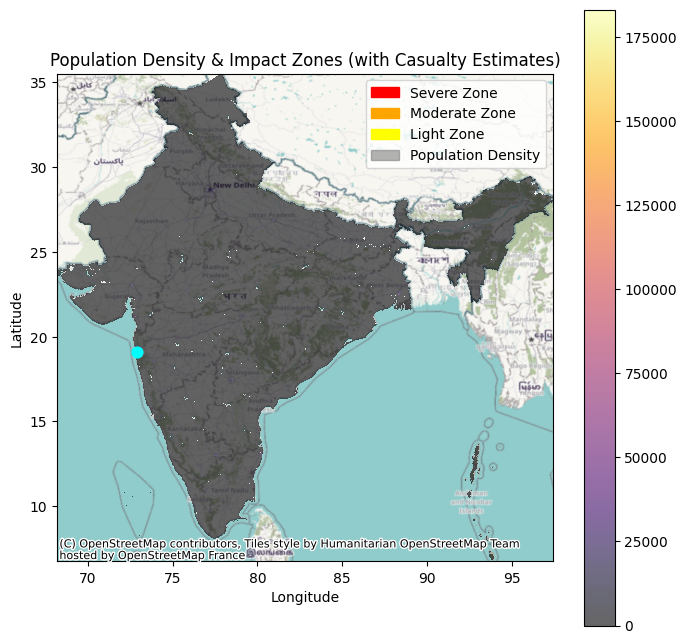


=== Estimated Population Exposure & Casualties ===
Zone       | Radius (km) |   Population | Fatality % |   Casualties
----------------------------------------------------------------
Severe     |        5.0 |     -978,401 |      90.0% |     -880,561
Moderate   |       10.0 |  -23,276,166 |      40.0% |   -9,310,467
Light      |       20.0 | -129,999,376 |      10.0% |  -12,999,938


In [ ]:
impact_lat, impact_lon = 19.0760, 72.8777  # Mumbai
radii_km = {'severe': 5, 'moderate': 10, 'light': 20}

results = plot_population_overlay(
    pop_raster_path=pop_raster_path,
    impact_lat=impact_lat,
    impact_lon=impact_lon,
    radii_km=radii_km
)

In [ ]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import contextily as ctx
from shapely.geometry import Point

def plot_population_overlay(pop_raster_path, impact_lat, impact_lon, radii_km):
    """
    Loads a population raster and plots it with impact damage rings overlaid.
    """
    # 1. Load the population raster data
    pop_data = rxr.open_rasterio(pop_raster_path, masked=True).squeeze()

    # Use a logarithmic color scale for better visualization of population density
    norm = LogNorm(vmin=1, vmax=pop_data.max())

    # 2. Set up the plot
    fig, ax = plt.subplots(figsize=(12, 12))

    # 3. Plot the population raster
    pop_data.plot.imshow(ax=ax, cmap='viridis', norm=norm, add_colorbar=True, cbar_kwargs={'label': 'Population per 100m cell (log scale)'})

    # 4. Create and plot the damage polygons
    # Create a GeoDataFrame for the impact point
    impact_point = gpd.GeoDataFrame(
        {'geometry': [Point(impact_lon, impact_lat)]}, crs='EPSG:4326'
    )
    # Project to a CRS that uses meters (like Web Mercator) for accurate buffering
    impact_point_proj = impact_point.to_crs(epsg=3857)

    for level, radius in radii_km.items():
        color = {'severe': 'red', 'moderate': 'orange', 'light': 'yellow'}[level]

        circle_proj = impact_point_proj.buffer(radius * 1000)
        circle_latlon = circle_proj.to_crs(epsg=4326)

        circle_latlon.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2, label=f'{level.capitalize()} Damage ({radius} km)')

    # 5. Add a marker for the impact point
    impact_point.plot(ax=ax, marker='X', color='white', markersize=150, label='Impact Point')

    # 6. Add a basemap for context
    ctx.add_basemap(ax, crs=pop_data.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    ax.set_title(f'Population Density Overlay for Impact at ({impact_lat:.2f}, {impact_lon:.2f})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    plt.show()

# --- Now, you can call the function ---
# Make sure the pop_raster_path variable is defined correctly

# Example Run (for Mumbai) - Commented out to avoid running inside the function definition
# impact_lat, impact_lon = 19.0760, 72.8777  # Mumbai
# radii_km = {'severe': 5, 'moderate': 10, 'light': 20}

# results = plot_population_overlay(
    # pop_raster_path='data/worldpop_usa_2020.tif', # Incorrect path
    # impact_lat=impact_lat,
    # impact_lon=impact_lon,
    # radii_km=radii_km
# )

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
import numpy as np
import matplotlib.patches as mpatches

def plot_population_overlay(pop_raster_path, impact_lat, impact_lon, radii_km,
                            fatality_rates=None):
    """
    Plot population density overlay with impact zones, and estimate casualties.

    Parameters
    ----------
    pop_raster_path : str
        Path to the population GeoTIFF file.
    impact_lat, impact_lon : float
        Impact site coordinates.
    radii_km : dict
        Dictionary with zone names as keys and radii (in km) as values.
    fatality_rates : dict, optional
        Dict with fatality fraction per zone.
    """
    if fatality_rates is None:
        fatality_rates = {"severe": 0.9, "moderate": 0.4, "light": 0.1}

    # Load population raster
    pop_raster = rioxarray.open_rasterio(pop_raster_path, masked=True)
    pop_raster = pop_raster.squeeze()  # remove singleton dimension

    # Reproject to WGS84 (lat/lon) before plotting
    if pop_raster.rio.crs is not None and pop_raster.rio.crs != "EPSG:4326":
        pop_raster_reprojected = pop_raster.rio.reproject("EPSG:4326")
    elif pop_raster.rio.crs is None:
         # Assign CRS if missing, assuming EPSG:4326 based on WorldPop data
         pop_raster.rio.write_crs("EPSG:4326", inplace=True)
         pop_raster_reprojected = pop_raster # Use the raster with assigned CRS
    else:
        pop_raster_reprojected = pop_raster # Already in EPSG:4326


    # Prepare base map
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the reprojected raster
    pop_raster_reprojected.plot(ax=ax, cmap="inferno", alpha=0.6)

    # Define colors for each zone
    zone_colors = {"severe": "red", "moderate": "orange", "light": "yellow"}

    # Create GeoDataFrame of the impact site
    impact_point = gpd.GeoDataFrame(geometry=[Point(impact_lon, impact_lat)], crs="EPSG:4326")


    results = {}
    previous_radius_deg = 0

    # Sort radii_km keys to ensure plotting in correct order (largest last for visibility)
    sorted_zones = sorted(radii_km.items(), key=lambda item: item[1])


    for zone, radius_km in sorted_zones:
        # Convert km to approximate degrees (1° ≈ 111.32 km)
        radius_deg = radius_km / 111.32
        outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
        inner_circle = impact_point.buffer(previous_radius_deg).geometry.iloc[0] if previous_radius_deg > 0 else None

        # Zone polygon = ring between two circles
        if inner_circle:
            # Use symmetric_difference to handle potential topology issues with difference
            # Or ensure inner_circle is fully contained in outer_circle before difference
             if inner_circle.within(outer_circle):
                 ring = outer_circle.difference(inner_circle)
             else:
                 # If inner circle is not within outer, just use the outer circle (shouldn't happen with sorted radii)
                 ring = outer_circle
        else:
            ring = outer_circle

        # Mask population raster
        try:
            # Attempt rasterio mask first
            with rasterio.open(pop_raster_path) as src:
                 # Ensure the geometry is in the raster's CRS for masking
                 geom_in_raster_crs = gpd.GeoDataFrame(geometry=[ring], crs="EPSG:4326").to_crs(src.crs).geometry
                 clipped, transform = mask(src, geom_in_raster_crs, crop=True)
                 clipped_data = clipped[0]
        except Exception:
            # fallback to rioxarray clip if rasterio mask fails
            print(f"Warning: Rasterio mask failed for {zone} zone, falling back to rioxarray clip.")
            # Ensure the geometry is in the raster's CRS for clipping
            geom_in_raster_crs = gpd.GeoDataFrame(geometry=[ring], crs="EPSG:4326").to_crs(pop_raster.rio.crs).geometry
            clipped_da = pop_raster.rio.clip(geom_in_raster_crs, drop=True)
            clipped_data = clipped_da.values


        # Sum total population (skip NaNs)
        # Ensure clipped_data is a numpy array if it came from rioxarray DataArray values
        if isinstance(clipped_data, np.ndarray):
             total_pop = np.nansum(clipped_data)
        else:
             # If it's still an xarray DataArray (e.g., from the fallback), sum its values
             total_pop = float(clipped_data.sum().values)


        casualties = total_pop * fatality_rates.get(zone, 0)

        results[zone] = {
            "radius_km": radius_km,
            "population_exposed": int(total_pop),
            "fatality_rate": fatality_rates[zone],
            "estimated_casualties": int(casualties)
        }

        # Plot ring boundary
        # Ensure the circle is in the same CRS as the plot for adding to the axis
        circle_for_plot = gpd.GeoDataFrame([{'geometry': outer_circle}], crs="EPSG:4326")
        circle_for_plot.boundary.plot(ax=ax, color=zone_colors[zone], linewidth=1.5, label=f"{zone.capitalize()} Zone")
        previous_radius_deg = radius_deg

    # Plot impact site
    plt.scatter(impact_lon, impact_lat, color='cyan', s=60, label="Impact Site", zorder=5)
    plt.title("Population Density & Impact Zones (with Casualty Estimates)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Create legend manually
    handles = [mpatches.Patch(color=zone_colors[z], label=f"{z.capitalize()} Zone") for z in radii_km.keys()]
    # Add a placeholder for the population raster in the legend
    # You might need to create a custom legend handler or use a representative patch
    # For simplicity, I'll add a colored patch with a label
    handles.append(mpatches.Patch(color='grey', alpha=0.6, label='Population Density')) # Using grey as a placeholder color
    plt.legend(handles=handles, loc="upper right")

    # Optional: Add basemap for context
    try:
        impact_point_for_basemap = impact_point.to_crs(epsg=3857)
        # Plot a dummy point in the new CRS to set the extent for contextily
        impact_point_for_basemap.plot(ax=ax, alpha=0) # alpha=0 makes it invisible
        ctx.add_basemap(ax, crs='EPSG:4326') # Use the original CRS for adding basemap
    except Exception as e:
        print(f"Could not add basemap: {e}")
        pass


    plt.show()

    # Print detailed breakdown
    print("\n=== Estimated Population Exposure & Casualties ===")
    print(f"{'Zone':<10} | {'Radius (km)':>10} | {'Population':>12} | {'Fatality %':>10} | {'Casualties':>12}")
    print("-" * 64)
    # Sort results by radius for clear printing
    sorted_results = sorted(results.items(), key=lambda item: item[1]['radius_km'])
    for zone, info in sorted_results:
        print(f"{zone.capitalize():<10} | {info['radius_km']:>10.1f} | {info['population_exposed']:>12,} | "
              f"{info['fatality_rate']*100:>9.1f}% | {info['estimated_casualties']:>12,}")


    return results

/tmp/ipython-input-3147062474.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
/tmp/ipython-input-3147062474.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
/tmp/ipython-input-3147062474.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inner_circle = impact_point.buffer(previous_radius_deg).geometry.iloc[0] if previous_radius_deg > 0 else None
/tmp/ipython-input-3147062474.py:66: UserWarning: Geometry is in a geographic CRS. Results from 

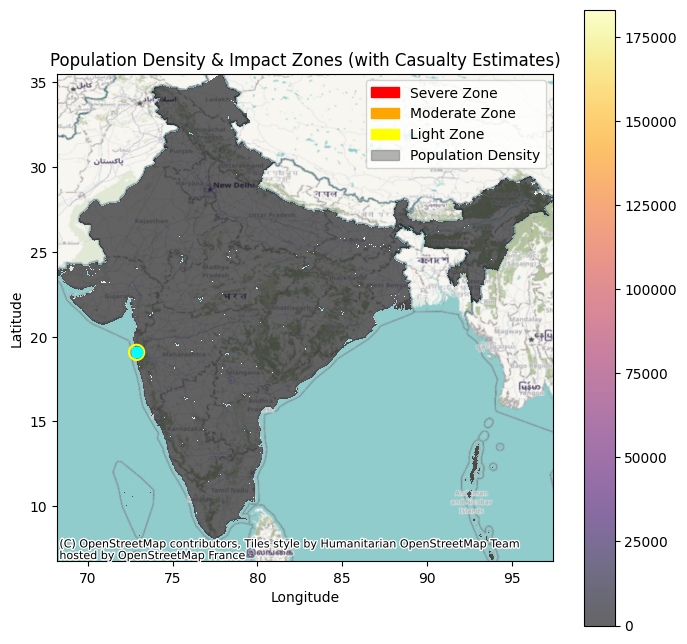


=== Estimated Population Exposure & Casualties ===
Zone       | Radius (km) |   Population | Fatality % |   Casualties
----------------------------------------------------------------
Severe     |       10.0 |  -11,054,699 |      90.0% |   -9,949,229
Moderate   |       25.0 | -185,937,312 |      40.0% |  -74,374,928
Light      |       50.0 | -803,178,688 |      10.0% |  -80,317,872


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
import numpy as np
import matplotlib.patches as mpatches

def plot_population_overlay(pop_raster_path, impact_lat, impact_lon, radii_km,
                            fatality_rates=None):
    """
    Plot population density overlay with impact zones, and estimate casualties.

    Parameters
    ----------
    pop_raster_path : str
        Path to the population GeoTIFF file.
    impact_lat, impact_lon : float
        Impact site coordinates.
    radii_km : dict
        Dictionary with zone names as keys and radii (in km) as values.
    fatality_rates : dict, optional
        Dict with fatality fraction per zone.
    """
    if fatality_rates is None:
        fatality_rates = {"severe": 0.9, "moderate": 0.4, "light": 0.1}

    # Load population raster
    pop_raster = rioxarray.open_rasterio(pop_raster_path, masked=True)
    pop_raster = pop_raster.squeeze()  # remove singleton dimension

    # Reproject to WGS84 (lat/lon) before plotting
    if pop_raster.rio.crs is not None and pop_raster.rio.crs != "EPSG:4326":
        pop_raster_reprojected = pop_raster.rio.reproject("EPSG:4326")
    elif pop_raster.rio.crs is None:
         # Assign CRS if missing, assuming EPSG:4326 based on WorldPop data
         pop_raster.rio.write_crs("EPSG:4326", inplace=True)
         pop_raster_reprojected = pop_raster # Use the raster with assigned CRS
    else:
        pop_raster_reprojected = pop_raster # Already in EPSG:4326


    # Prepare base map
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the reprojected raster
    pop_raster_reprojected.plot(ax=ax, cmap="inferno", alpha=0.6)

    # Define colors for each zone
    zone_colors = {"severe": "red", "moderate": "orange", "light": "yellow"}

    # Create GeoDataFrame of the impact site
    impact_point = gpd.GeoDataFrame(geometry=[Point(impact_lon, impact_lat)], crs="EPSG:4326")


    results = {}
    previous_radius_deg = 0

    # Sort radii_km keys to ensure plotting in correct order (largest last for visibility)
    sorted_zones = sorted(radii_km.items(), key=lambda item: item[1])


    for zone, radius_km in sorted_zones:
        # Convert km to approximate degrees (1° ≈ 111.32 km)
        radius_deg = radius_km / 111.32
        outer_circle = impact_point.buffer(radius_deg).geometry.iloc[0]
        inner_circle = impact_point.buffer(previous_radius_deg).geometry.iloc[0] if previous_radius_deg > 0 else None

        # Zone polygon = ring between two circles
        if inner_circle:
            # Use symmetric_difference to handle potential topology issues with difference
            # Or ensure inner_circle is fully contained in outer_circle before difference
             if inner_circle.within(outer_circle):
                 ring = outer_circle.difference(inner_circle)
             else:
                 # If inner circle is not within outer, just use the outer circle (shouldn't happen with sorted radii)
                 ring = outer_circle
        else:
            ring = outer_circle

        # Mask population raster
        try:
            # Attempt rasterio mask first
            with rasterio.open(pop_raster_path) as src:
                 # Ensure the geometry is in the raster's CRS for masking
                 geom_in_raster_crs = gpd.GeoDataFrame(geometry=[ring], crs="EPSG:4326").to_crs(src.crs).geometry
                 clipped, transform = mask(src, geom_in_raster_crs, crop=True)
                 clipped_data = clipped[0]
        except Exception:
            # fallback to rioxarray clip if rasterio mask fails
            print(f"Warning: Rasterio mask failed for {zone} zone, falling back to rioxarray clip.")
            # Ensure the geometry is in the raster's CRS for clipping
            geom_in_raster_crs = gpd.GeoDataFrame(geometry=[ring], crs="EPSG:4326").to_crs(pop_raster.rio.crs).geometry
            clipped_da = pop_raster.rio.clip(geom_in_raster_crs, drop=True)
            clipped_data = clipped_da.values


        # Sum total population (skip NaNs)
        # Ensure clipped_data is a numpy array if it came from rioxarray DataArray values
        if isinstance(clipped_data, np.ndarray):
             total_pop = np.nansum(clipped_data)
        else:
             # If it's still an xarray DataArray (e.g., from the fallback), sum its values
             total_pop = float(clipped_data.sum().values)


        casualties = total_pop * fatality_rates.get(zone, 0)

        results[zone] = {
            "radius_km": radius_km,
            "population_exposed": int(total_pop),
            "fatality_rate": fatality_rates[zone],
            "estimated_casualties": int(casualties)
        }

        # Plot ring boundary
        # Ensure the circle is in the same CRS as the plot for adding to the axis
        circle_for_plot = gpd.GeoDataFrame([{'geometry': outer_circle}], crs="EPSG:4326")
        circle_for_plot.boundary.plot(ax=ax, color=zone_colors[zone], linewidth=1.5, label=f"{zone.capitalize()} Zone")
        previous_radius_deg = radius_deg

    # Plot impact site
    plt.scatter(impact_lon, impact_lat, color='cyan', s=60, label="Impact Site", zorder=5)
    plt.title("Population Density & Impact Zones (with Casualty Estimates)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Create legend manually
    handles = [mpatches.Patch(color=zone_colors[z], label=f"{z.capitalize()} Zone") for z in radii_km.keys()]
    # Add a placeholder for the population raster in the legend
    # You might need to create a custom legend handler or use a representative patch
    # For simplicity, I'll add a colored patch with a label
    handles.append(mpatches.Patch(color='grey', alpha=0.6, label='Population Density')) # Using grey as a placeholder color
    plt.legend(handles=handles, loc="upper right")

    # Optional: Add basemap for context
    try:
        impact_point_for_basemap = impact_point.to_crs(epsg=3857)
        # Plot a dummy point in the new CRS to set the extent for contextily
        impact_point_for_basemap.plot(ax=ax, alpha=0) # alpha=0 makes it invisible
        ctx.add_basemap(ax, crs='EPSG:4326') # Use the original CRS for adding basemap
    except Exception as e:
        print(f"Could not add basemap: {e}")
        pass


    plt.show()

    # Print detailed breakdown
    print("\n=== Estimated Population Exposure & Casualties ===")
    print(f"{'Zone':<10} | {'Radius (km)':>10} | {'Population':>12} | {'Fatality %':>10} | {'Casualties':>12}")
    print("-" * 64)
    # Sort results by radius for clear printing
    sorted_results = sorted(results.items(), key=lambda item: item[1]['radius_km'])
    for zone, info in sorted_results:
        print(f"{zone.capitalize():<10} | {info['radius_km']:>10.1f} | {info['population_exposed']:>12,} | "
              f"{info['fatality_rate']*100:>9.1f}% | {info['estimated_casualties']:>12,}")


    return results


# === Example Run (for Mumbai) ===
impact_lat = 19.0760
impact_lon = 72.8777
radii_km = {"severe": 10, "moderate": 25, "light": 50}
# Corrected population raster path
pop_raster_path = "/content/worldpop.tif"

results = plot_population_overlay(pop_raster_path, impact_lat, impact_lon, radii_km)

# Mitigation Strategies

In [ ]:
import numpy as np
from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Sun, Earth
from typing import Optional, Tuple


G = 6.67430e-11 * u.m**3 / u.kg / u.s**2
g0 = 9.80665 * u.m / u.s**2

def _asteroid_mass_from_diameter(diameter: u.m, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    return (4.0 / 3.0) * np.pi * (diameter / 2) ** 3 * density

def _unit_vector(vec) -> u.dimensionless_unscaled:
    if not isinstance(vec, u.Quantity):
        try:
            vec = np.array(vec) * u.one
            if np.linalg.norm(vec.value) > 1e-6:
                 pass
        except Exception:
             raise TypeError("Input vector must be an Astropy Quantity or convertible to one.")



    if isinstance(vec, (list, tuple)) and all(isinstance(x, u.Quantity) for x in vec):
         vec = u.Quantity(vec)


    if not isinstance(vec, u.Quantity):
         raise TypeError("Input vector could not be converted to an Astropy Quantity.")



    vec_value = vec.value
    mag_value = np.linalg.norm(vec_value)

    if mag_value == 0:
        return np.zeros_like(vec_value) * u.dimensionless_unscaled


    unit_vec_value = vec_value / mag_value
    return unit_vec_value * u.dimensionless_unscaled


def get_asteroid_mass_from_neo(neo_json, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    try:
        diameter_min = neo_json['estimated_diameter']['meters']['estimated_diameter_min']
        diameter_max = neo_json['estimated_diameter']['meters']['estimated_diameter_max']
        diameter = ((diameter_min + diameter_max) / 2.0) * u.m
        return _asteroid_mass_from_diameter(diameter, density)
    except KeyError:
        raise ValueError("Estimated diameter data not found in NEO JSON for mass estimation.")


def kinetic_impactor(
    neo_json: dict,
    orbit: Orbit,
    impactor_mass: u.kg,
    impactor_velocity_rel: u.m / u.s,
    beta: float = 0.0,
    impact_direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    momentum = (1.0 + beta) * impactor_mass * impactor_velocity_rel

    delta_v_mag = (momentum / asteroid_mass).to(u.m / u.s)

    r_vec, v_vec = orbit.rv()
    if impact_direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = (-v_hat).to(u.dimensionless_unscaled)
    else:
        dir_vec = _unit_vector(impact_direction).to(u.dimensionless_unscaled)


    delta_v_vec = (delta_v_mag * dir_vec).to(u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + delta_v_vec).to(u.m / u.s)

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec.to(u.m), new_v, orbit.epoch)

    return new_orbit, delta_v_mag


def propagate_with_constant_thrust(orbit: Orbit, time_duration: u.s, thrust_accel_magnitude: u.m / u.s**2, direction: Optional[u.dimensionless_unscaled] = None) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:
    r_vec, v_vec = orbit.rv()

    if direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = (-v_hat).to(u.dimensionless_unscaled)
    else:
         dir_vec = _unit_vector(direction).to(u.dimensionless_unscaled)


    total_delta_v_vec = (thrust_accel_magnitude * time_duration).to(u.m / u.s) * dir_vec
    total_delta_v_mag = np.linalg.norm(total_delta_v_vec.value) * (u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + total_delta_v_vec).to(u.m / u.s)
    new_epoch = orbit.epoch + TimeDelta(time_duration)

    orb_at_new_epoch = orbit.propagate(time_duration)
    r_vec_at_new_epoch, _ = orb_at_new_epoch.rv()


    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec_at_new_epoch.to(u.m), new_v, new_epoch)

    return new_orbit, total_delta_v_vec, total_delta_v_mag


def gravity_tractor(
    neo_json: dict,
    orbit: Orbit,
    tractor_mass: u.kg,
    separation_distance: u.m,
    time_duration: u.s,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)



    accel_magnitude = (G * tractor_mass / separation_distance ** 2).to(u.m / u.s**2)


    return new_orbit, delta_v_mag


def laser_ablation(
    neo_json: dict,
    orbit: Orbit,
    laser_power: u.W,
    ablation_isp: u.s,
    time_duration: u.s,
    efficiency: float = 0.5,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:

    initial_asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    v_exhaust = (g0 * ablation_isp).to(u.m / u.s)
    thrust_magnitude = (2 * efficiency * laser_power / v_exhaust).to(u.N)



    accel_magnitude = (thrust_magnitude / initial_asteroid_mass).to(u.m / u.s**2)


    return new_orbit, delta_v_mag


def nuclear_option(
    neo_json: dict,
    orbit: Orbit,
    explosive_yield: u.J,
    coupling_factor: float = 0.1,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    imparted_ke = (coupling_factor * explosive_yield).to(u.J)

    if imparted_ke.value < 0:
        imparted_ke = 0 * u.J
        print("Warning: Calculated imparted kinetic energy was negative, setting to zero.")

    arg_sqrt = (2 * imparted_ke / asteroid_mass).to(u.m ** 2 / u.s ** 2)
    if arg_sqrt.value < 0:
         delta_v_mag = 0 * (u.m / u.s)
         print("Warning: Argument of sqrt for delta_v magnitude was negative, setting delta_v to zero.")
    else:
        delta_v_mag = np.sqrt(arg_sqrt).to(u.m / u.s)


    r_vec, v_vec = orbit.rv()
    if direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = v_hat.to(u.dimensionless_unscaled)
    else:
         dir_vec = _unit_vector(direction).to(u.dimensionless_unscaled)

    delta_v_vec = (delta_v_mag * dir_vec).to(u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + delta_v_vec).to(u.m / u.s)

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec.to(u.m), new_v, orbit.epoch)

    return new_orbit, delta_v_mag

In [ ]:
# === Asteroid Deflection Demo (User Input + 3D Plot) ===

import numpy as np
from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Sun, Earth
from typing import Optional, Tuple
import matplotlib.pyplot as plt

# ---------------- Constants ----------------
G = 6.67430e-11 * u.m**3 / u.kg / u.s**2
g0 = 9.80665 * u.m / u.s**2

# ---------------- Utility Functions ----------------
def _asteroid_mass_from_diameter(diameter: u.m, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    return (4/3) * np.pi * (diameter/2)**3 * density

def _unit_vector(vec) -> u.dimensionless_unscaled:
    # Ensure input is an Astropy Quantity
    if not isinstance(vec, u.Quantity):
        vec = np.array(vec) * u.one # Assume dimensionless if no unit provided

    # Calculate magnitude using the value, then reapply unit if needed (norm is dimensionless for unit vectors)
    mag_value = np.linalg.norm(vec.value)

    if mag_value == 0:
        # Return a zero vector with dimensionless unit
        return np.zeros_like(vec.value) * u.dimensionless_unscaled
    else:
        # Divide value by magnitude and return with dimensionless unit
        unit_vec_value = vec.value / mag_value
        return unit_vec_value * u.dimensionless_unscaled


def get_asteroid_mass_from_neo(neo_json, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    diameter = ((neo_json['estimated_diameter']['meters']['estimated_diameter_min'] +
                 neo_json['estimated_diameter']['meters']['estimated_diameter_max']) / 2.0) * u.m
    return _asteroid_mass_from_diameter(diameter, density)

# ---------------- Deflection Methods ----------------
def kinetic_impactor(neo_json, orbit: Orbit, impactor_mass: u.kg, impactor_velocity_rel: u.m/u.s, beta=0.0):
    asteroid_mass = get_asteroid_mass_from_neo(neo_json)
    delta_v_mag = ((1+beta) * impactor_mass * impactor_velocity_rel / asteroid_mass).to(u.m/u.s)
    r_vec, v_vec = orbit.rv()
    delta_v_vec = -_unit_vector(v_vec) * delta_v_mag
    new_v = (v_vec.to(u.m/u.s) + delta_v_vec.to(u.m/u.s)).to(u.m/u.s) # Convert to common unit before adding
    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec, new_v, orbit.epoch)
    return new_orbit

def propagate_with_constant_thrust(orbit: Orbit, time_duration: u.s, thrust_accel_magnitude: u.m / u.s**2, direction: Optional[u.dimensionless_unscaled] = None):
    r_vec_at_new_epoch, _ = orbit.propagate(time_duration).rv()
    v_vec_current = orbit.rv()[1]

    if direction is None:
        v_hat = _unit_vector(v_vec_current)
        dir_vec = (-v_hat).to(u.dimensionless_unscaled)
    else:
         dir_vec = _unit_vector(direction).to(u.dimensionless_unscaled)

    total_delta_v_vec = (thrust_accel_magnitude * time_duration).to(u.m / u.s) * dir_vec
    total_delta_v_mag = np.linalg.norm(total_delta_v_vec.value) * (u.m / u.s) # Calculate magnitude after vector

    new_v = (v_vec_current.to(u.m/u.s) + total_delta_v_vec.to(u.m/u.s)).to(u.m/u.s) # Convert to common unit before adding
    new_epoch = orbit.epoch + TimeDelta(time_duration)

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec_at_new_epoch.to(u.m), new_v, new_epoch)

    return new_orbit


def gravity_tractor(neo_json, orbit: Orbit, tractor_mass: u.kg, separation_distance: u.m, duration: u.s):
    accel = (G * tractor_mass / separation_distance**2).to(u.m/u.s**2)
    # Use propagate_with_constant_thrust which now handles direction and unit conversion
    return propagate_with_constant_thrust(orbit, duration, accel, direction=-_unit_vector(orbit.rv()[1]))

def laser_ablation(neo_json, orbit: Orbit, laser_power: u.W, ablation_isp: u.s, duration: u.s, efficiency=0.5):
    m_ast = get_asteroid_mass_from_neo(neo_json)
    v_exhaust = (g0 * ablation_isp).to(u.m/u.s)
    thrust = (2*efficiency*laser_power / v_exhaust).to(u.N)
    accel = (thrust / m_ast).to(u.m/u.s**2)
    # Use propagate_with_constant_thrust which now handles direction and unit conversion
    return propagate_with_constant_thrust(orbit, duration, accel, direction=-_unit_vector(orbit.rv()[1]))

def nuclear_option(neo_json, orbit: Orbit, explosive_yield: u.J, coupling_factor=0.1):
    m_ast = get_asteroid_mass_from_neo(neo_json)
    imparted_ke = (coupling_factor * explosive_yield).to(u.J)

    if imparted_ke.value < 0:
        imparted_ke = 0 * u.J
        print("Warning: Calculated imparted kinetic energy was negative, setting to zero.")

    arg_sqrt = (2 * imparted_ke / m_ast).to(u.m ** 2 / u.s ** 2)
    if arg_sqrt.value < 0:
         delta_v_mag = 0 * (u.m / u.s)
         print("Warning: Argument of sqrt for delta_v magnitude was negative, setting delta_v to zero.")
    else:
        delta_v_mag = np.sqrt(arg_sqrt).to(u.m / u.s)

    r_vec, v_vec = orbit.rv()
    # Assume nuclear blast pushes in direction of velocity for deflection
    dir_vec = _unit_vector(v_vec).to(u.dimensionless_unscaled)
    delta_v_vec = (delta_v_mag * dir_vec).to(u.m / u.s)

    new_v = (v_vec.to(u.m/u.s) + delta_v_vec.to(u.m/u.s)).to(u.m/u.s) # Convert to common unit before adding

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec.to(u.m), new_v, orbit.epoch)

    return new_orbit

# ---------------- Orbit Sampling for Plot ----------------
def sample_orbit_positions(orbit, duration, num_points=300):
    times = np.linspace(0, duration.to(u.s).value, num_points) * u.s
    positions = []
    for t in times:
        # Propagate and explicitly convert position to km before getting the value
        pos_vec = orbit.propagate(t).rv()[0].to(u.km)
        positions.append(pos_vec.value)
    return np.array(positions)

# ------------------- User Inputs -------------------
print("=== Asteroid Properties ===")
diam_min = float(input("Min diameter (m): "))
diam_max = float(input("Max diameter (m): "))
density = float(input("Density (kg/m³, default 3000): ") or 3000)
neo_json = {"estimated_diameter": {"meters":{"estimated_diameter_min":diam_min,"estimated_diameter_max":diam_max}}}

print("\n=== Orbit Definition ===")
# Simple circular orbit around Sun
r0 = float(input("Initial orbit radius from Sun (km, e.g., 1.5e8 for 1 AU): ")) * u.km
# Use Sun.k for the gravitational parameter (GM)
# Calculate initial velocity for a circular orbit at r0
v0_mag = np.sqrt((Sun.k / r0).to(u.m**2/u.s**2)).to(u.m/u.s)
# Create an initial orbit - need a position and velocity vector
# Let's place it on the x-axis and give it velocity in the +y direction
r0_vec = [r0.to(u.m).value, 0, 0] * u.m
v0_vec = [0, v0_mag.to(u.m/u.s).value, 0] * u.m/u.s
neo_orbit = Orbit.from_vectors(Sun, r0_vec, v0_vec, Time.now())


print("\n=== Mitigation Method ===")
method = input("Choose mitigation (kinetic/gravity/laser/nuclear): ").lower()
prop_days = float(input("Propagation duration after deflection (days, default 365): ") or 365)
prop_duration = prop_days * u.day

# ------------------- Method Parameters -------------------
if method == "kinetic":
    mass = float(input("Impactor mass (kg): "))
    vel = float(input("Impactor relative velocity (km/s): ")) * u.km/u.s
    beta = float(input("Momentum enhancement factor beta (0-2, default 0): ") or 0)
    new_orbit = kinetic_impactor(neo_json, neo_orbit, mass*u.kg, vel.to(u.m/u.s), beta)

elif method == "gravity":
    tractor_mass = float(input("Tractor mass (kg): "))
    separation = float(input("Separation distance (m): "))
    duration_days = float(input("Duration (days): "))
    new_orbit = gravity_tractor(neo_json, neo_orbit, tractor_mass*u.kg, separation*u.m, duration_days*u.day)

elif method == "laser":
    power = float(input("Laser power (W): "))
    isp = float(input("Ablation Isp (s): "))
    duration_days = float(input("Duration (days): "))
    efficiency = float(input("Efficiency (0-1, default 0.5): ") or 0.5)
    new_orbit = laser_ablation(neo_json, neo_orbit, power*u.W, isp*u.s, duration_days*u.day, efficiency)

elif method == "nuclear":
    yield_kt = float(input("Explosive yield (kilotons TNT): "))
    coupling = float(input("Coupling factor (0-1, default 0.1): ") or 0.1)
    explosive_yield = yield_kt * 4.184e12 * u.J
    new_orbit = nuclear_option(neo_json, neo_orbit, explosive_yield, coupling)

else:
    raise ValueError("Invalid mitigation method")

# ------------------- Plot Trajectories -------------------
pos_orig = sample_orbit_positions(neo_orbit, prop_duration)
pos_new = sample_orbit_positions(new_orbit, prop_duration)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_orig[:,0], pos_orig[:,1], pos_orig[:,2], label="Original Orbit", color="black")
ax.plot(pos_new[:,0], pos_new[:,1], pos_new[:,2], label=f"{method.capitalize()} Deflection", color="red")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.set_title("Asteroid Orbit Deflection")
ax.legend()
ax.view_init(elev=30, azim=45)
plt.show()

In [ ]:
# Impact simulation


import math
import json
from typing import Dict, Any, List, Tuple
import numpy as np

EARTH_RADIUS_M = 6371000.0

def km_to_m(x_km: float) -> float:
    return x_km * 1000.0

def kmps_to_mps(x_kmps: float) -> float:
    return x_kmps * 1000.0

def gcm3_to_kgm3(x_gcm3: float) -> float:
    return x_gcm3 * 1000.0

def circle_latlon(center_lat: float, center_lon: float, radius_m: float, n_points: int = 64) -> List[Tuple[float,float]]:
    """
    Return a list of lat/lon points approximating a circle of radius_m around center point.
    Uses a simple equirectangular approximation with Earth's radius.
    """
    lat = math.radians(center_lat)
    lon = math.radians(center_lon)
    points = []
    for i in range(n_points):
        theta = 2.0 * math.pi * float(i) / n_points
        dx = radius_m * math.cos(theta)
        dy = radius_m * math.sin(theta)
        # offset in lat/lon
        dlat = dy / EARTH_RADIUS_M
        dlon = dx / (EARTH_RADIUS_M * math.cos(lat))
        plat = math.degrees(lat + dlat)
        plon = math.degrees(lon + dlon)
        points.append((plat, plon))
    return points

def compute_mass_from_size(size_km: float, density_gcm3: float) -> Tuple[float,float]:
    """
    Returns (radius_m, mass_kg)
    Assumes spherical asteroid.
    """
    radius_m = km_to_m(size_km) / 2.0
    density = gcm3_to_kgm3(density_gcm3)
    volume = (4.0/3.0) * math.pi * radius_m**3
    mass_kg = volume * density
    return radius_m, mass_kg

def compute_kinetic_energy(mass_kg: float, velocity_kmps: float) -> float:
    v_ms = kmps_to_mps(velocity_kmps)
    E_j = 0.5 * mass_kg * v_ms**2
    return E_j

def estimate_crater_radius_m(energy_j: float, target_density_kgm3: float = 2500.0):
    """
    A simplified, conservative estimate for transient crater radius (meters).
    WARNING: This is an approximation for demonstration/education. Replace with Holsapple
    scaling laws for precise scientific work.

    Approach:
      - Use an empirical power-law relating impact energy to crater diameter:
        D_transient (m) ≈ C * (E_J)^(1/3.4)
      - Choose C so numbers are reasonable (C ~= 1e-2 to get crater km-scale for large energies).
    The exponent and constant are adjustable.
    """
    # Tunable constants (documented as simplifications)
    exponent = 1.0 / 3.4
    C = 5.0e-2     # constant chosen to give plausible-scale craters for typical bolide energies
    D_transient_m = C * (energy_j ** exponent)
    R_transient_m = D_transient_m / 2.0
    # A small safety floor
    R_transient_m = max(R_transient_m, 1.0)
    return R_transient_m

def estimate_seismic_magnitude(energy_j: float, coupling_fraction: float = 1e-4):
    """
    Rough conversion of impact kinetic energy to an equivalent seismic moment magnitude Mw.
    Steps:
      - seismic_energy ≈ coupling_fraction * impact_energy
      - Mw approximated by: Mw ≈ (2/3) * log10(SeismicEnergy_J) - 6.06
        (this is an empirical relationship mapping seismic moment/energy to magnitude; constants approximate)
    coupling_fraction: fraction of impact energy that couples into seismic energy; ranges widely in literature.
    """
    seismic_energy_j = energy_j * coupling_fraction
    if seismic_energy_j <= 0:
        return 0.0
    # Avoid math domain error
    mw = (2.0/3.0) * (math.log10(seismic_energy_j) if seismic_energy_j > 0 else -10) - 6.06
    # Limit to reasonable range
    mw = max(min(mw, 12.0), -1.0)
    return round(mw, 2)

def estimate_tsunami_initial_height_m(energy_j: float, ocean_depth_m: float = 4000.0):
    """
    Very rough initial tsunami amplitude estimator for an ocean impact close to shore.
    Not a substitute for hydrodynamic modeling.
    Heuristic: wave height scales sub-linearly with impact energy and depends on ocean depth.
    """
    # Tunable heuristics
    # Normalize energy to a baseline and take a fractional power
    h = 0.02 * (energy_j ** 0.25) / (ocean_depth_m ** 0.5)   # meters
    # cap to a reasonable maximum for display
    h = max(min(h, 500.0), 0.0)
    return h

def angular_distance_km(lat1, lon1, lat2, lon2):
    # Haversine distance in km
    r = EARTH_RADIUS_M / 1000.0
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2.0)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2.0)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return r * c

def simulate_impact(
    size_km: float,
    velocity_kms: float,
    density_gcm3: float = 3.0,
    impact_lat: float = 0.0,
    impact_lon: float = 0.0,
    impact_angle_deg: float = 45.0,
    target_density_kgm3: float = 2500.0,
    ocean_depth_m: float = 4000.0,
    return_geojson_polygons: bool = True
) -> Dict[str, Any]:
    """
    Runs the simplified impact simulation and returns a dictionary suitable for your frontend.
    Fields included:
      - asteroid: original params
      - impact: energy_j, crater_radius_m, seismic_Mw, tsunami_initial_height_m
      - geo: crater_circle (list of lat/lon), tsunami_circle (if ocean impact)
    Notes: This is a demonstrative approximation. For better accuracy, replace crater scaling with Holsapple or validated models.
    """
    # 1) mass & energy
    radius_m, mass_kg = compute_mass_from_size(size_km, density_gcm3)
    energy_j = compute_kinetic_energy(mass_kg, velocity_kms)

    # 2) crater estimate (transient crater radius)
    crater_radius_m = estimate_crater_radius_m(energy_j, target_density_kgm3=target_density_kgm3)

    # 3) seismic magnitude estimate
    seismic_mw = estimate_seismic_magnitude(energy_j, coupling_fraction=1e-5)  # choose modest coupling

    # 4) tsunami (only meaningful if impact in ocean - frontend should inform if cell's on ocean)
    tsunami_h_m = estimate_tsunami_initial_height_m(energy_j, ocean_depth_m=ocean_depth_m)

    # 5) approximate affected distances (for mapping concentric rings)
    blast_ring_1_m = crater_radius_m * 1.0        # immediate crater
    blast_ring_2_m = crater_radius_m * 5.0        # heavy damage radius (heuristic)
    blast_ring_3_m = crater_radius_m * 20.0       # noticeable effects radius

    result = {
        "asteroid": {
            "size_km": size_km,
            "velocity_kms": velocity_kms,
            "density_gcm3": density_gcm3,
            "impact_angle_deg": impact_angle_deg
        },
        "impact": {
            "energy_j": energy_j,
            "crater_radius_m": crater_radius_m,
            "seismic_Mw": seismic_mw,
            "tsunami_initial_height_m": tsunami_h_m,
            "blast_rings_m": {
                "crater_m": blast_ring_1_m,
                "heavy_damage_m": blast_ring_2_m,
                "noticeable_effects_m": blast_ring_3_m
            },
            "impact_location": {
                "lat": impact_lat,
                "lon": impact_lon
            }
        }
    }

    # optional: polygon circles for mapping overlays (simple lat/lon circle)
    if return_geojson_polygons:
        result["geo"] = {
            "crater_circle": circle_latlon(impact_lat, impact_lon, blast_ring_1_m, n_points=64),
            "heavy_damage_circle": circle_latlon(impact_lat, impact_lon, blast_ring_2_m, n_points=64),
            "noticeable_effects_circle": circle_latlon(impact_lat, impact_lon, blast_ring_3_m, n_points=64),
        }
        # If ocean, provide a tsunami radius polygon (very rough)
        # heuristic tsunami radius (km) proportional to (energy)^(1/4)
        tsunami_radius_km = min(2000.0, (energy_j ** 0.25) * 1e-3)  # tunable
        result["geo"]["tsunami_circle"] = circle_latlon(impact_lat, impact_lon, tsunami_radius_km*1000.0, n_points=128)
        result["impact"]["tsunami_radius_km"] = tsunami_radius_km

    return result

# ------------------------
# Example usage (try these in your notebook)
# ------------------------
if __name__ == "__main__":
    # Example: 200 m asteroid (0.2 km), 20 km/s, density 3 g/cm3, hits near Mumbai approx lat/lon
    example = simulate_impact(
        size_km=0.2,
        velocity_kms=20.0,
        density_gcm3=3.0,
        impact_lat=19.0760,
        impact_lon=72.8777,
        impact_angle_deg=45.0,
        ocean_depth_m=4000.0
    )
    # pretty-print summary
    print("Asteroid:", example["asteroid"])
    print("Impact Energy (J):", example["impact"]["energy_j"])
    print("Crater radius (m):", round(example["impact"]["crater_radius_m"], 1))
    print("Estimated seismic Mw:", example["impact"]["seismic_Mw"])
    print("Tsunami initial height (m):", round(example["impact"]["tsunami_initial_height_m"], 2))


In [ ]:
import numpy as np
from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Sun, Earth
from typing import Optional, Tuple


G = 6.67430e-11 * u.m**3 / u.kg / u.s**2
g0 = 9.80665 * u.m / u.s**2

def _asteroid_mass_from_diameter(diameter: u.m, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    return (4.0 / 3.0) * np.pi * (diameter / 2) ** 3 * density

def _unit_vector(vec) -> u.dimensionless_unscaled:
    if not isinstance(vec, u.Quantity):
        try:
            vec = np.array(vec) * u.one
            if np.linalg.norm(vec.value) > 1e-6:
                 pass
        except Exception:
             raise TypeError("Input vector must be an Astropy Quantity or convertible to one.")


    if isinstance(vec, (list, tuple)) and all(isinstance(x, u.Quantity) for x in vec):
         vec = u.Quantity(vec)


    if not isinstance(vec, u.Quantity):
         raise TypeError("Input vector could not be converted to an Astropy Quantity.")



    vec_value = vec.value
    mag_value = np.linalg.norm(vec_value)

    if mag_value == 0:
        return np.zeros_like(vec_value) * u.dimensionless_unscaled


    unit_vec_value = vec_value / mag_value
    return unit_vec_value * u.dimensionless_unscaled


def get_asteroid_mass_from_neo(neo_json, density: u.kg / u.m**3 = 3000 * u.kg / u.m**3) -> u.kg:
    try:
        diameter_min = neo_json['estimated_diameter']['meters']['estimated_diameter_min']
        diameter_max = neo_json['estimated_diameter']['meters']['estimated_diameter_max']
        diameter = ((diameter_min + diameter_max) / 2.0) * u.m
        return _asteroid_mass_from_diameter(diameter, density)
    except KeyError:
        raise ValueError("Estimated diameter data not found in NEO JSON for mass estimation.")


def kinetic_impactor(
    neo_json: dict,
    orbit: Orbit,
    impactor_mass: u.kg,
    impactor_velocity_rel: u.m / u.s,
    beta: float = 0.0,
    impact_direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    momentum = (1.0 + beta) * impactor_mass * impactor_velocity_rel

    delta_v_mag = (momentum / asteroid_mass).to(u.m / u.s)

    r_vec, v_vec = orbit.rv()
    if impact_direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = (-v_hat).to(u.dimensionless_unscaled)
    else:
        dir_vec = _unit_vector(impact_direction).to(u.dimensionless_unscaled)


    delta_v_vec = (delta_v_mag * dir_vec).to(u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + delta_v_vec).to(u.m / u.s)

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec.to(u.m), new_v, orbit.epoch)

    return new_orbit, delta_v_mag


def propagate_with_constant_thrust(orbit: Orbit, time_duration: u.s, thrust_accel_magnitude: u.m / u.s**2, direction: Optional[u.dimensionless_unscaled] = None) -> Tuple[Orbit, u.m / u.s, u.m / u.s]:
    r_vec, v_vec = orbit.rv()

    if direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = (-v_hat).to(u.dimensionless_unscaled)
    else:
         dir_vec = _unit_vector(direction).to(u.dimensionless_unscaled)


    total_delta_v_vec = (thrust_accel_magnitude * time_duration).to(u.m / u.s) * dir_vec
    total_delta_v_mag = np.linalg.norm(total_delta_v_vec.value) * (u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + total_delta_v_vec).to(u.m / u.s)
    new_epoch = orbit.epoch + TimeDelta(time_duration)

    orb_at_new_epoch = orbit.propagate(time_duration)
    r_vec_at_new_epoch, _ = orb_at_new_epoch.rv()


    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec_at_new_epoch.to(u.m), new_v, new_epoch)

    return new_orbit, total_delta_v_vec, total_delta_v_mag


def gravity_tractor(
    neo_json: dict,
    orbit: Orbit,
    tractor_mass: u.kg,
    separation_distance: u.m,
    time_duration: u.s,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)



    accel_magnitude = (G * tractor_mass / separation_distance ** 2).to(u.m / u.s**2)

    # Use propagate_with_constant_thrust to get delta_v and new orbit
    new_orbit, delta_v_vec, delta_v_mag = propagate_with_constant_thrust(orbit, time_duration, accel_magnitude, direction=direction)

    return new_orbit, delta_v_mag


def laser_ablation(
    neo_json: dict,
    orbit: Orbit,
    laser_power: u.W,
    ablation_isp: u.s,
    time_duration: u.s,
    efficiency: float = 0.5,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s]:

    initial_asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    v_exhaust = (g0 * ablation_isp).to(u.m / u.s)
    thrust_magnitude = (2 * efficiency * laser_power / v_exhaust).to(u.N)



    accel_magnitude = (thrust_magnitude / initial_asteroid_mass).to(u.m / u.s**2)

    # Use propagate_with_constant_thrust to get delta_v and new orbit
    new_orbit, delta_v_vec, delta_v_mag = propagate_with_constant_thrust(orbit, time_duration, accel_magnitude, direction=direction)

    return new_orbit, delta_v_mag


def nuclear_option(
    neo_json: dict,
    orbit: Orbit,
    explosive_yield: u.J,
    coupling_factor: float = 0.1,
    direction: Optional[u.dimensionless_unscaled] = None,
) -> Tuple[Orbit, u.m / u.s]:

    asteroid_mass = get_asteroid_mass_from_neo(neo_json)

    imparted_ke = (coupling_factor * explosive_yield).to(u.J)

    if imparted_ke.value < 0:
        imparted_ke = 0 * u.J
        print("Warning: Calculated imparted kinetic energy was negative, setting to zero.")

    arg_sqrt = (2 * imparted_ke / asteroid_mass).to(u.m ** 2 / u.s ** 2)
    if arg_sqrt.value < 0:
         delta_v_mag = 0 * (u.m / u.s)
         print("Warning: Argument of sqrt for delta_v magnitude was negative, setting delta_v to zero.")
    else:
        delta_v_mag = np.sqrt(arg_sqrt).to(u.m / u.s)


    r_vec, v_vec = orbit.rv()
    if direction is None:
        v_hat = _unit_vector(v_vec)
        dir_vec = v_hat.to(u.dimensionless_unscaled)
    else:
         dir_vec = _unit_vector(direction).to(u.dimensionless_unscaled)

    delta_v_vec = (delta_v_mag * dir_vec).to(u.m / u.s)

    new_v = (v_vec.to(u.m / u.s) + delta_v_vec).to(u.m / u.s)

    new_orbit = Orbit.from_vectors(orbit.attractor, r_vec.to(u.m), new_v, orbit.epoch)

    return new_orbit, delta_v_mag

In [ ]:
# Comparison Function
import pandas as pd
import numpy as np # Import numpy here
from astropy import units as u
from poliastro.twobody.orbit import Orbit # Import Orbit here

def compare_mitigation_strategies(neo_json, initial_orbit: Orbit, lead_time_years=10):
    """
    Runs several pre-defined mitigation scenarios and compares their effectiveness.
    """
    lead_time = lead_time_years * u.year

    # --- Define Standard Scenarios (Budgets) ---
    scenarios = {
        "Kinetic Impactor": {
            "method": kinetic_impactor,
            "params": {"impactor_mass": 1000 * u.kg, "impactor_velocity_rel": 10 * u.km/u.s, "beta": 2.0}
        },
        "Gravity Tractor": {
            "method": gravity_tractor,
            "params": {"tractor_mass": 20000 * u.kg, "separation_distance": 200 * u.m, "time_duration": 5 * u.year}
        },
        "Laser Ablation": {
            "method": laser_ablation,
            "params": {"laser_power": 1e6 * u.W, "ablation_isp": 3000 * u.s, "time_duration": 2 * u.year}
        },
        "Nuclear Standoff (1 MT)": {
            "method": nuclear_option,
            "params": {"explosive_yield": 4.184e15 * u.J, "coupling_factor": 0.1}
        }
    }

    results = []

    # --- Calculate Baseline (Original) Miss Distance ---
    print("Propagating original orbit...")
    _, original_dists = propagate_and_geocentric(initial_orbit, [lead_time.to(u.day).value])
    original_miss_km = original_dists[0].to(u.km).value

    print(f"Baseline: Original orbit misses Earth by {original_miss_km:,.2f} km in {lead_time_years} years.")

    # --- Run and Compare Scenarios ---
    for name, scen in scenarios.items():
        print(f"Simulating {name}...")
        method = scen["method"]
        params = scen["params"]

        # Apply the deflection
        # The mitigation methods should now return (deflected_orbit, delta_v_mag)
        deflected_orbit, delta_v = method(neo_json=neo_json, orbit=initial_orbit, **params)

        # Propagate the new orbit and find its miss distance
        _, new_dists = propagate_and_geocentric(deflected_orbit, [lead_time.to(u.day).value])
        new_miss_km = new_dists[0].to(u.km).value

        results.append({
            "Method": name,
            "Delta-V (m/s)": round(delta_v.to(u.m/u.s).value, 4),
            "Final Miss Distance (km)": round(new_miss_km, 2),
            "Deflection Achieved (km)": round(new_miss_km - original_miss_km, 2)
        })

    # --- Format and Return Results ---
    df = pd.DataFrame(results)
    df = df.sort_values(by="Deflection Achieved (km)", ascending=False).reset_index(drop=True)
    return df

# --- Comparing Mitigation Strategies (10-Year Lead Time) ---
print("\n--- Comparing Mitigation Strategies (10-Year Lead Time) ---")
# Ensure 'neo' and 'orbit' are defined from previous steps, e.g., by running cell `adpbCI6v_U7A` first.
comparison_df = compare_mitigation_strategies(neo, orbit, lead_time_years=10)
print(comparison_df.to_string())